In [200]:
from glob import glob
from typing import Callable, Dict, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, RationalQuadratic,
                                              ExpSineSquared, DotProduct,Matern,
                                              ConstantKernel as C,WhiteKernel)


plt.style.use("figs/matplotlibrc")
cmap = mpl.colormaps["Paired"]

In [201]:
# for hparam_path in glob(f"results/saved_models/*/*/*/*.yaml"):
#     with open(hparam_path, "r") as file:
#         content = file.read()
#         content = content.replace("!!python/name:experiments.model.vit.ViT ''", "ViT")
# 
#     with open(hparam_path, "w") as file:
#         file.write(content)

In [202]:

# for csv_path in glob(f"results/saved_models/OneCycleLR2/*/*/*.csv"):
#     df = pd.read_csv(csv_path)
#     max_lr = df["lr-AdamW"].max()
#     
#     one_cylce_hparams = {
#         "lr_scheduler_hparams": {"max_lr": float(max_lr), "total_steps": 100},
#         "lr_scheduler_name": "OneCycleLR",
#         "model_cls": "ViT",
#         "model_hparams": {},
#         "optimizer_hparams": {"lr": float(max_lr), "weight_decay": 0.0001},
#         "optimizer_name": "AdamW",
#     }
#     h_param_path = "/".join(csv_path.split("/")[:-1]) + "/hparams.yaml"
#     print(h_param_path)
#     with open(h_param_path, "w") as file:
#         yaml.dump(one_cylce_hparams, file)


In [203]:
def build_results_df(results_dir: str = "results/saved_models") -> pd.DataFrame:
    dfs = []
    for csv_path in glob(f"{results_dir}/*/*/*/*.csv"):
        version = int(csv_path.split("/")[-2].split("_")[-1])
        experiment_name = csv_path.split("/")[-4]
        df = pd.read_csv(csv_path)
        if len(df) < 456:
            continue
        df = df[:456]
        df["version"] = version
        df["experiment_name"] = experiment_name
        epochs = np.arange(len(df["lr-AdamW"].dropna()))
        df.loc[~df["lr-AdamW"].isna(), "epoch"] = epochs
        
        # load hparams for scheduler
        h_param_path = "/".join(csv_path.split("/")[:-1]) + "/hparams.yaml"
        with open(h_param_path, "r") as file:
            content =  yaml.safe_load(file)

        
        df["lr"] = content["optimizer_hparams"]["lr"]
        for key, item in content["lr_scheduler_hparams"].items():
            df[key] = item
        dfs.append(df)

        last_lr_df = df[df["epoch"] == 99][
            ["experiment_name", "lr-AdamW", "version"]
        ].dropna()

        for idx in range(len(last_lr_df)):
            df.loc[
                (df["experiment_name"] == last_lr_df.iloc[idx]["experiment_name"])
                & (df["version"] == last_lr_df.iloc[idx]["version"])
                & (df["epoch"] == 100)
            , "lr-AdamW"] = last_lr_df.iloc[idx]["lr-AdamW"]


    return pd.concat(dfs, ignore_index=True)

def experiment_plot(func: Callable[[pd.DataFrame, str], Tuple[Figure, Axes]]):
    def wrapper(df, experiment_name, *args, save_path: str = None, **kwargs) -> Tuple[Figure, Axes]:
        if experiment_name not in df["experiment_name"].unique():
            print(f"No such experiment {experiment_name}. Please choose from: {df['experiment_name'].unique()}")
            return 
        fig, ax = func(df, experiment_name, *args, **kwargs)

        if save_path:
            fig.savefig(save_path)

        return fig, ax
    return wrapper

def get_color(df: pd.DataFrame, experiment_name: str, key: str, cmap_name: str = "viridis") -> Dict[float, np.ndarray]:
    cmap = mpl.colormaps[cmap_name]
    values = sorted(df[df["experiment_name"] == experiment_name][key].unique())
    colors = cmap(np.linspace(0, 1, len(values)))
    return dict(zip(values, colors))

def cerate_equal_query(search_criteria: pd.DataFrame) -> str:
    query = ""
    for row in search_criteria.to_numpy():
        a = ""
        for col_name, cell in zip(search_criteria.columns, row):
            if isinstance(cell, str):
                cell = f"'{cell}'"
            a += f"{col_name} == {cell} and "
        a = a[:-5]
        query += "(" + a + ")" + " or "
    query = query[:-4]
    return query


In [204]:
results_df = build_results_df()
display(results_df[:50])

,epoch,lr-AdamW,step,test_acc,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc_epoch,val_acc_step,...,experiment_name,lr,T_max,eta_min,gamma,step_size,factor,max_lr,total_steps,T_0
0,0.0,0.00001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,49,NaN,NaN,0.201172,NaN,2.171583,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,86,NaN,0.188510,NaN,2.194037,NaN,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.00001,87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,NaN,99,NaN,NaN,0.240234,NaN,2.044343,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,149,NaN,NaN,0.230469,NaN,2.009196,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
6,1.0,NaN,173,NaN,0.253457,NaN,2.018246,NaN,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
7,2.0,0.00001,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
8,2.0,NaN,199,NaN,NaN,0.261719,NaN,1.982229,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,NaN,249,NaN,NaN,0.273438,NaN,1.961545,NaN,NaN,...,CosineAnnealingLR,0.00001,100.0,0.000001,NaN,NaN,NaN,NaN,NaN,NaN


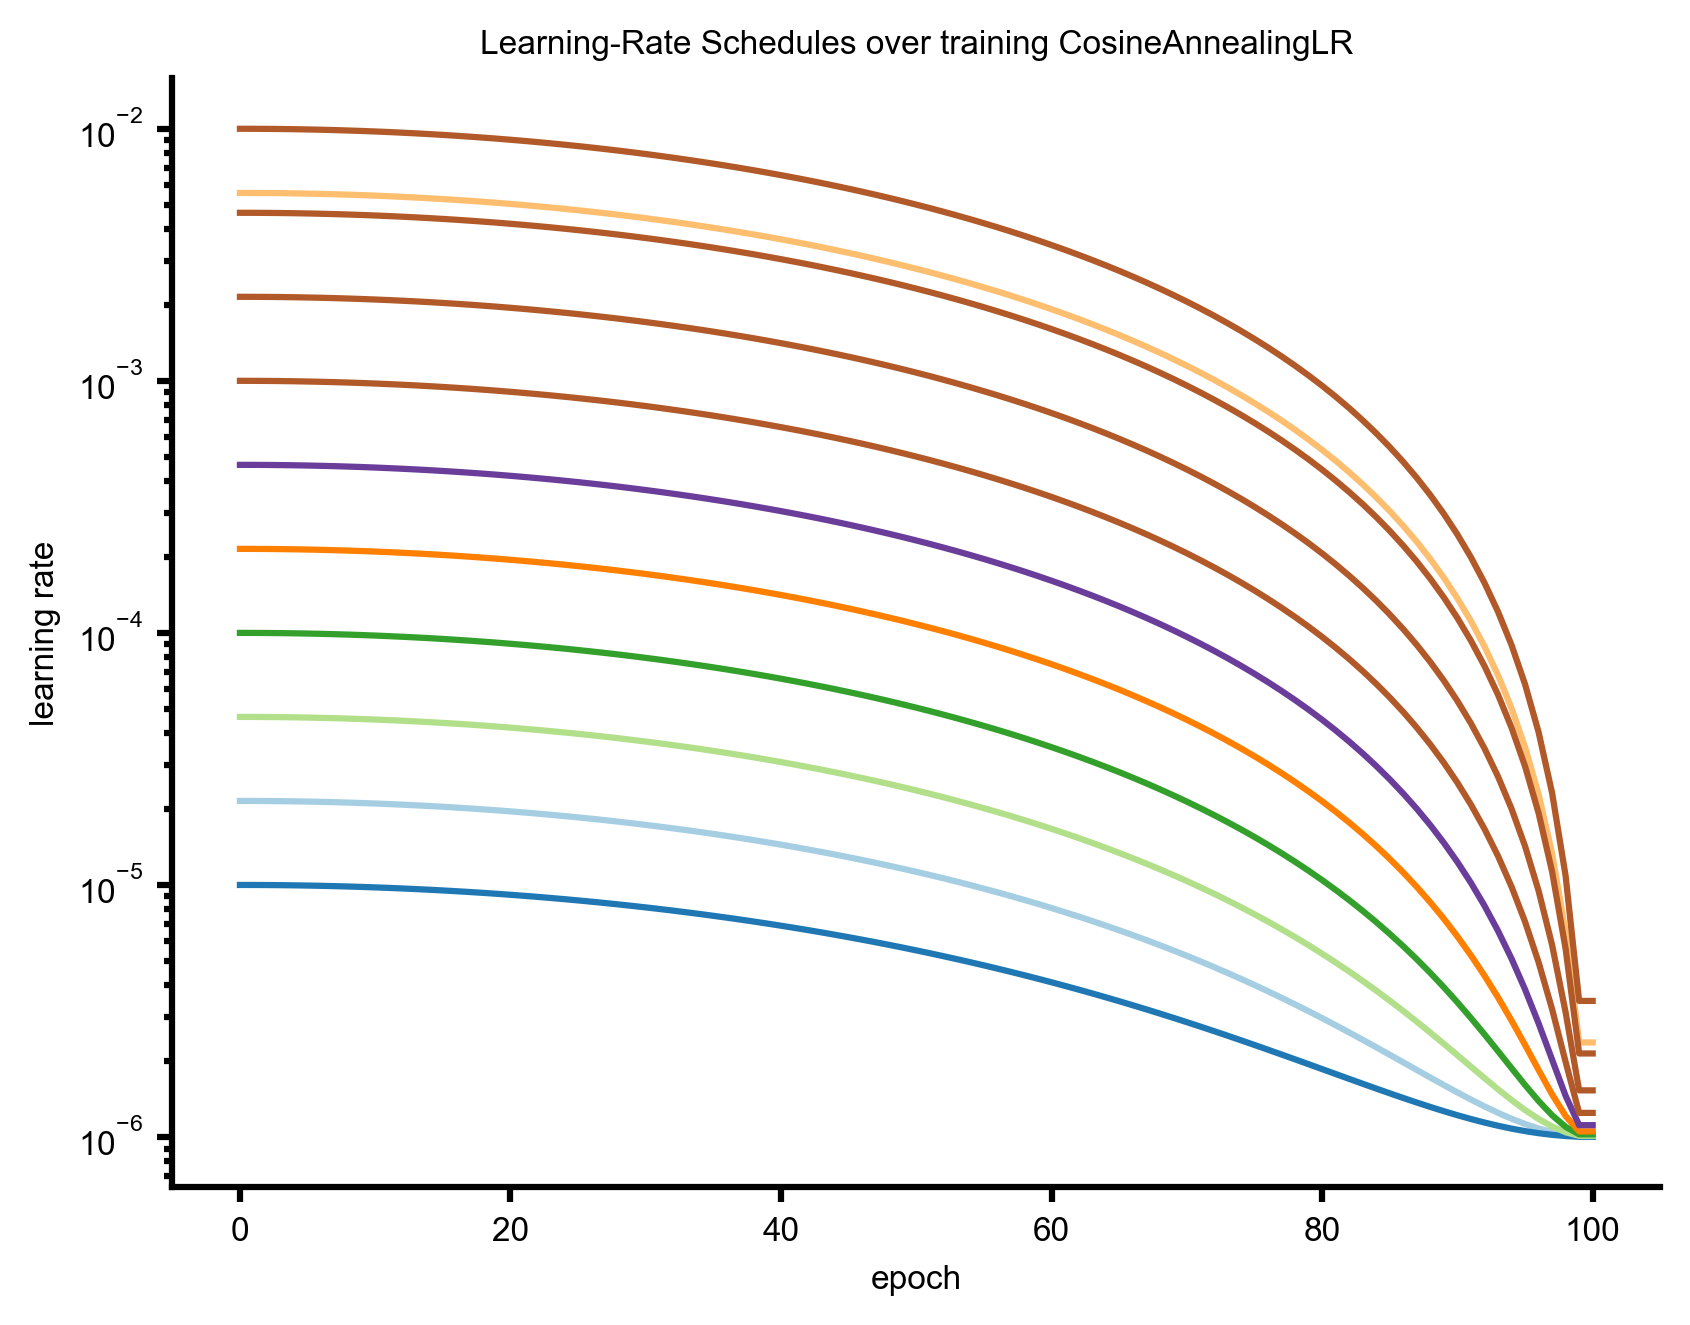

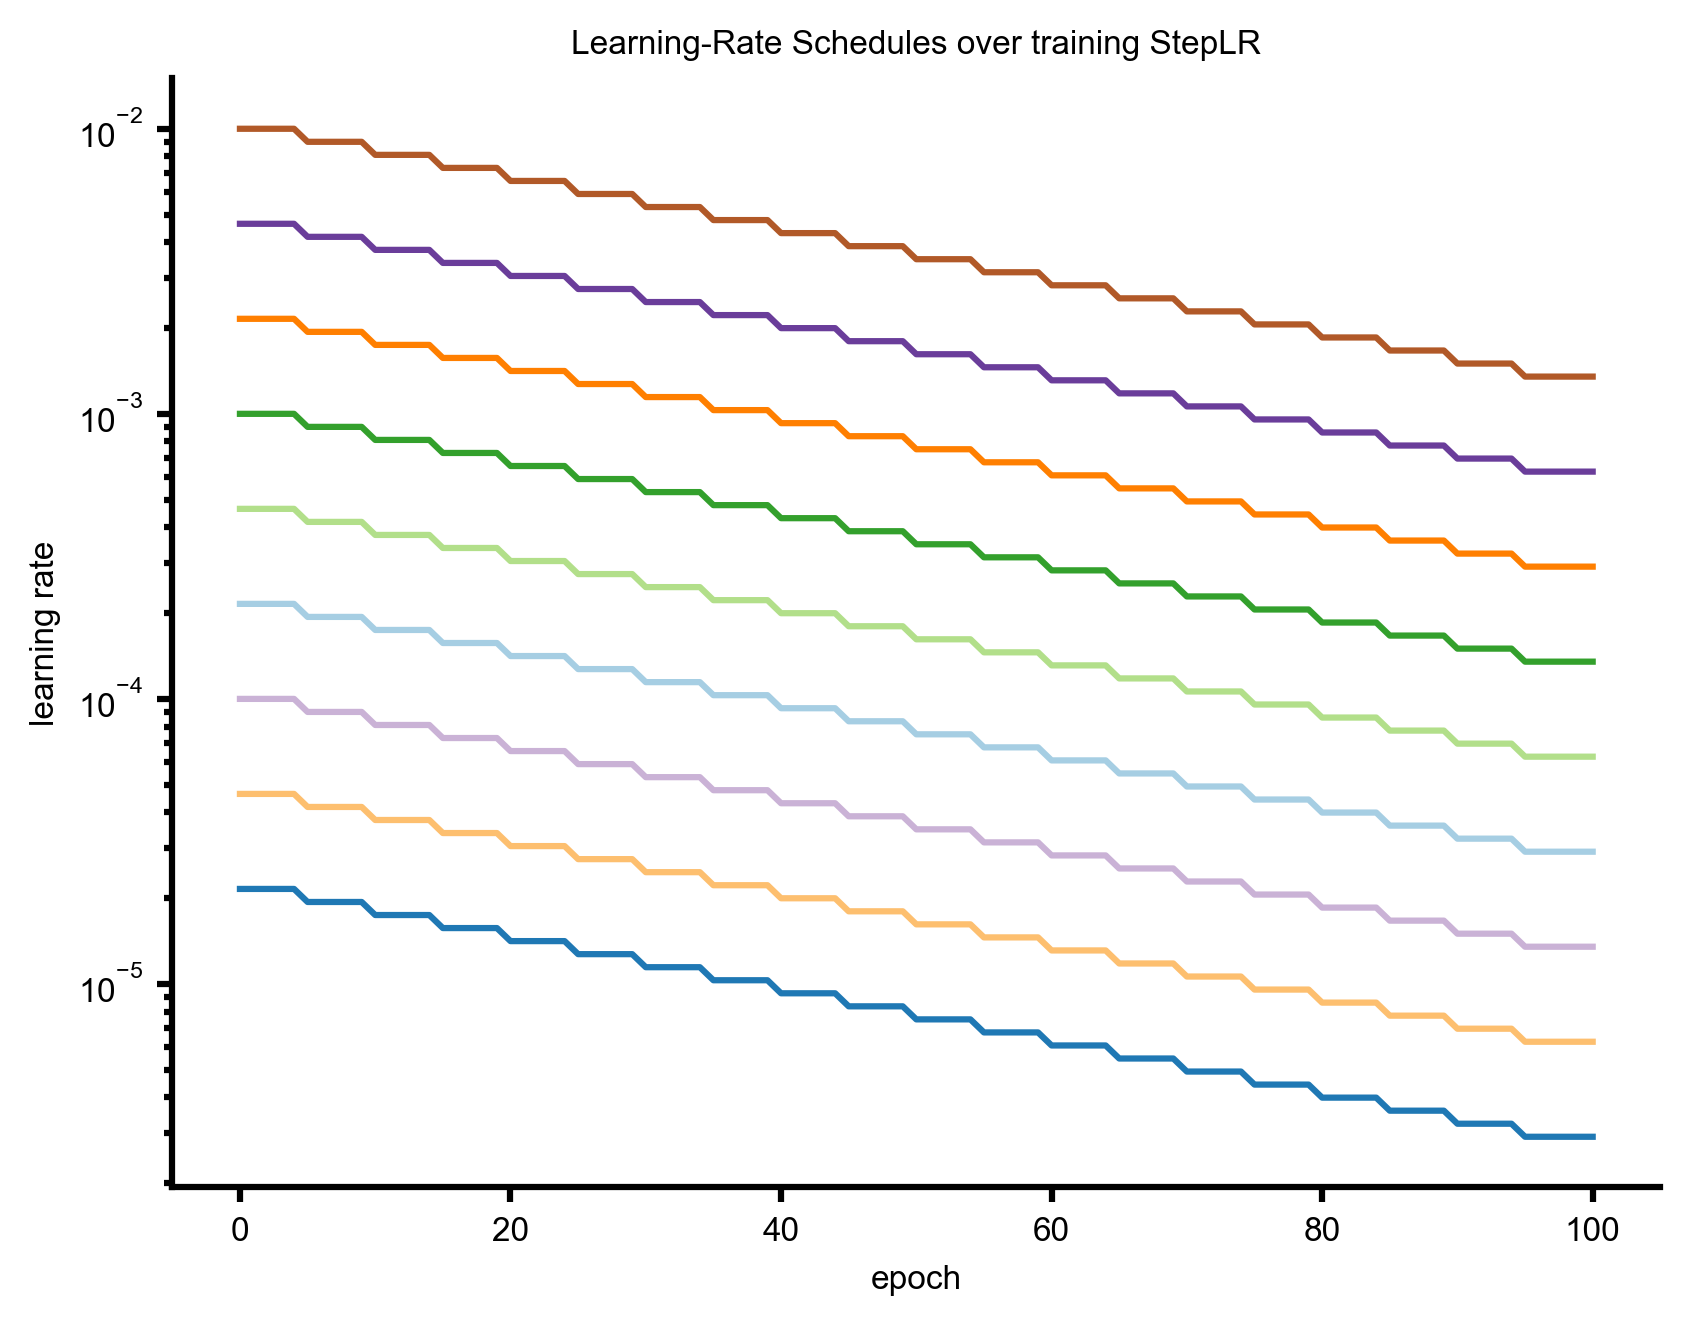

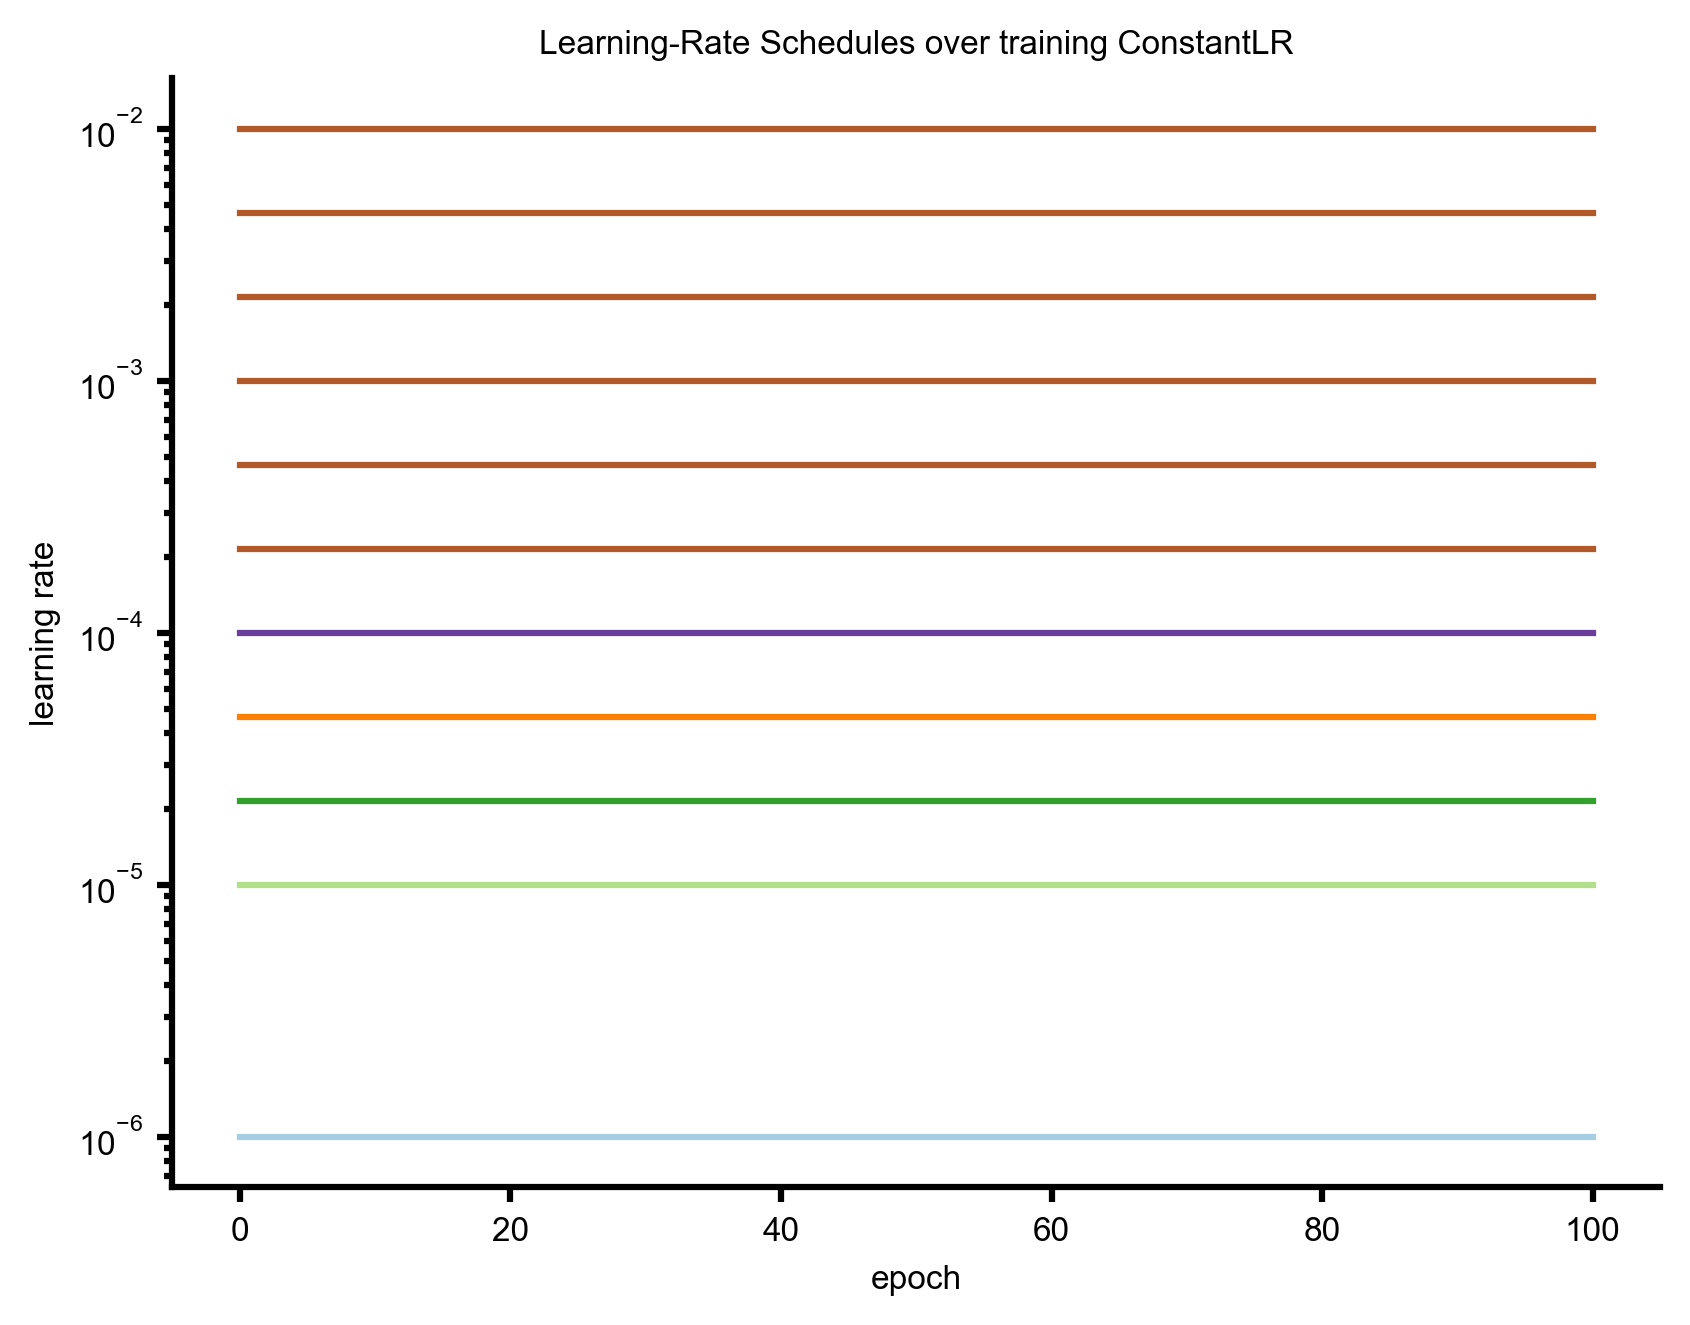

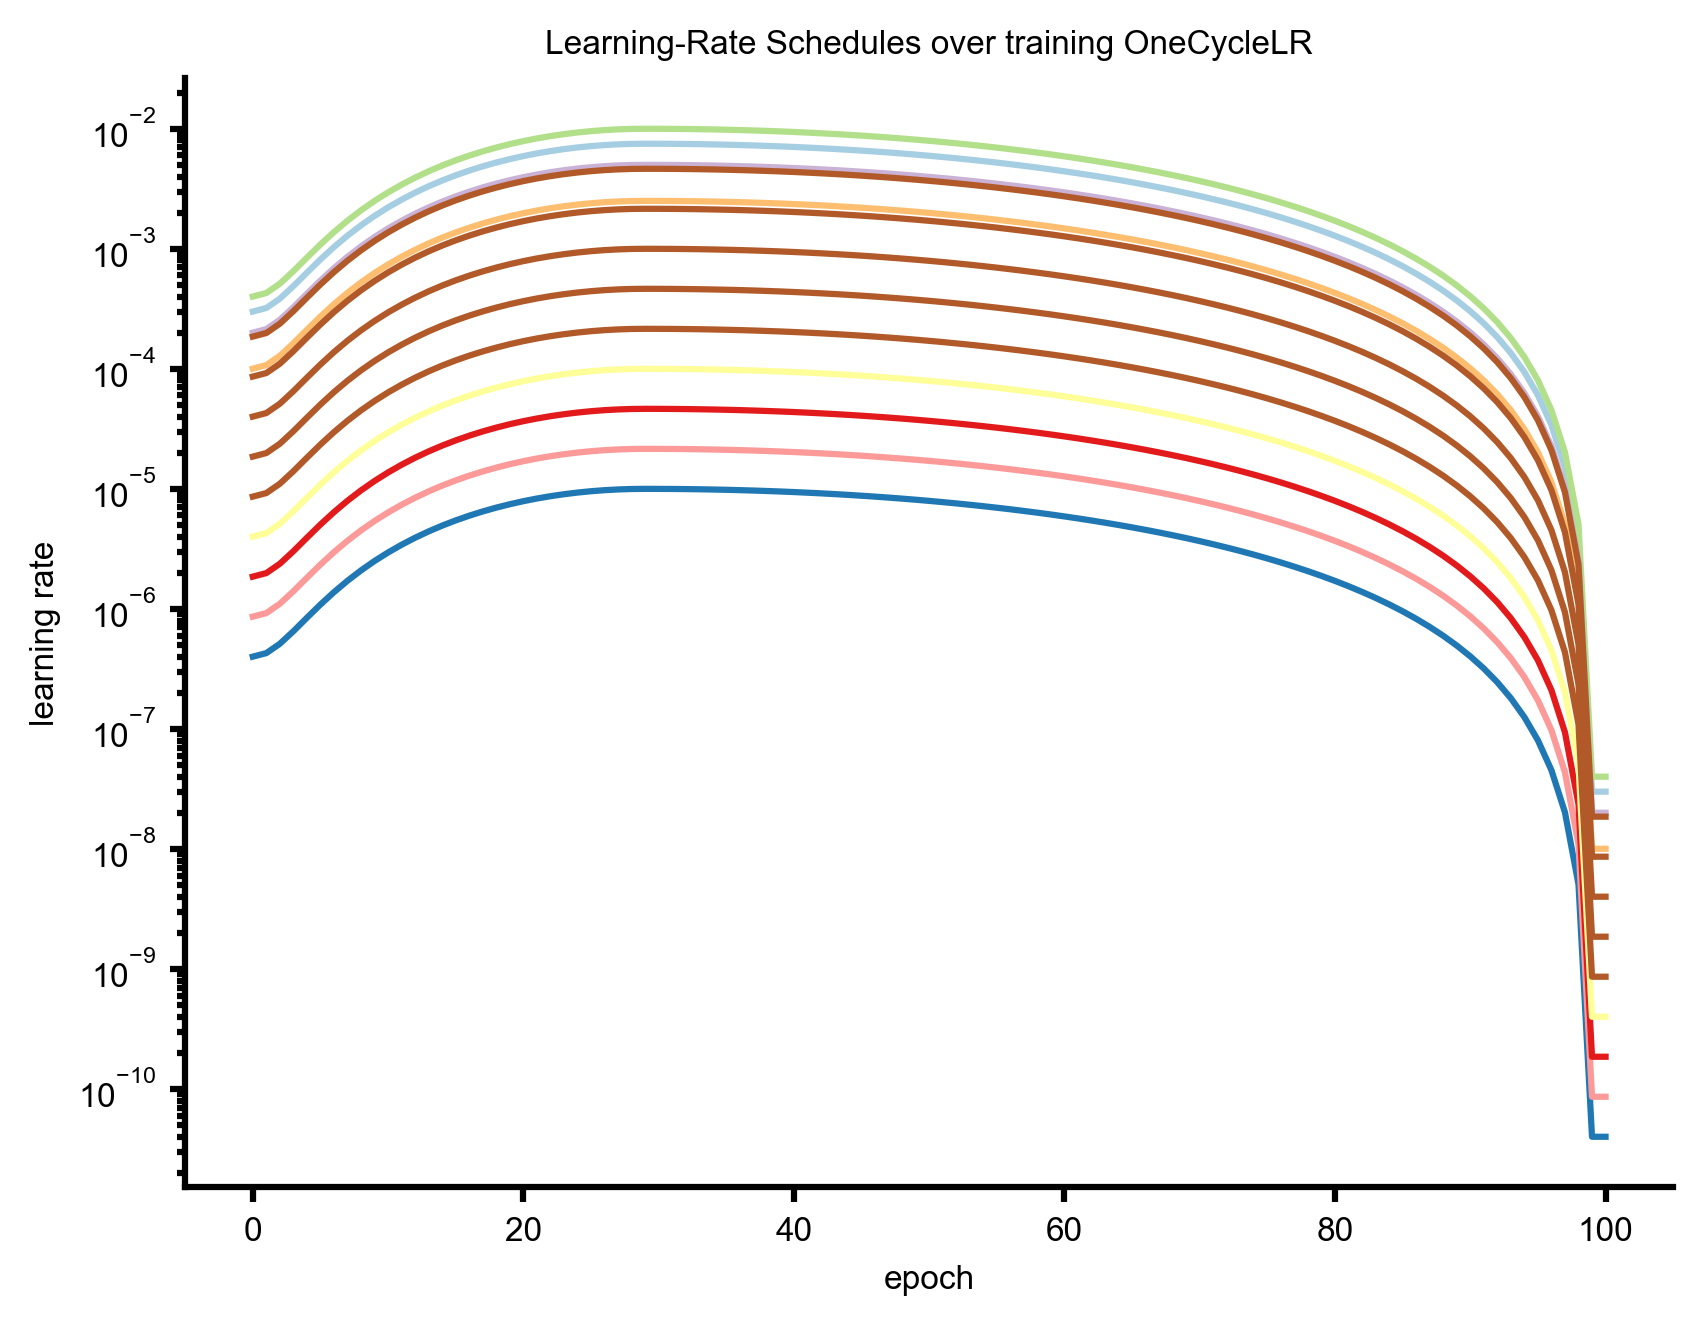

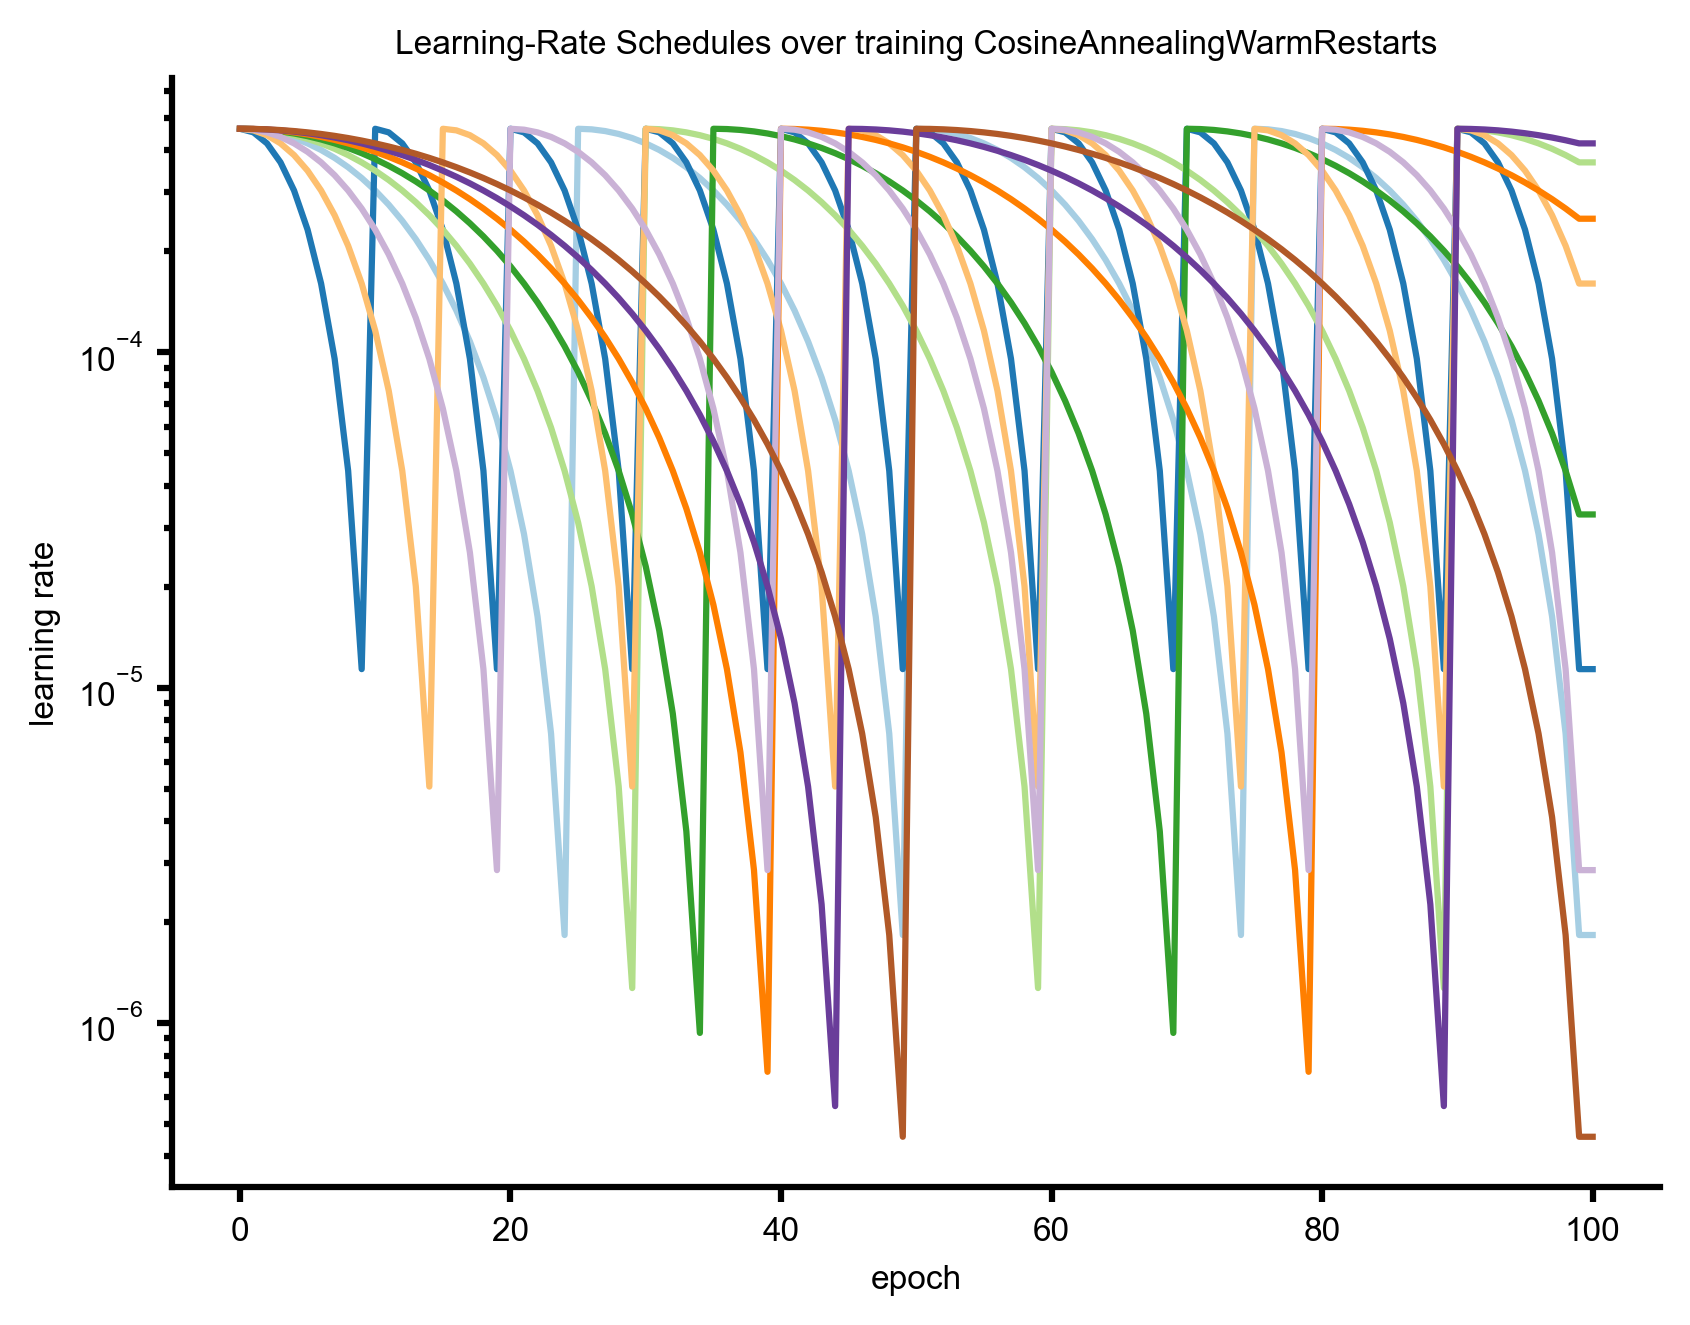

In [205]:
@experiment_plot
def plot_learning_rate(df: pd.DataFrame, experiment_name: str) -> Tuple[Figure, Axes]:    
    fig, ax = plt.subplots()
    
    for idx, version in enumerate(df.sort_values("lr")["version"].unique()):
        experiment_df = df[(df["experiment_name"] == experiment_name) & (df["version"] == version)][["epoch", "lr-AdamW"]].dropna()
        experiment_df = experiment_df.set_index("epoch")
        color = cmap(idx)
        ax.plot(experiment_df, c=color, label=f"version {version}")

    # ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("epoch")
    ax.set_ylabel("learning rate")
    ax.set_title(f"Learning-Rate Schedules over training {experiment_name}")

    return fig, ax

for experiment_name in results_df["experiment_name"].unique():
    plot_learning_rate(results_df, experiment_name)

No such experiment BaselineClassifier. Please choose from: ['CosineAnnealingLR' 'StepLR' 'ConstantLR' 'OneCycleLR'
 'CosineAnnealingWarmRestarts']
No such experiment BaselineClassifier. Please choose from: ['CosineAnnealingLR' 'StepLR' 'ConstantLR' 'OneCycleLR'
 'CosineAnnealingWarmRestarts']


(<Figure size 1920x1440 with 1 Axes>,
 <Axes: title={'center': 'Validation Accuracy for Learning Rate Scheduler CosineAnnealingWarmRestarts'}, xlabel='epoch', ylabel='Accuracy'>)

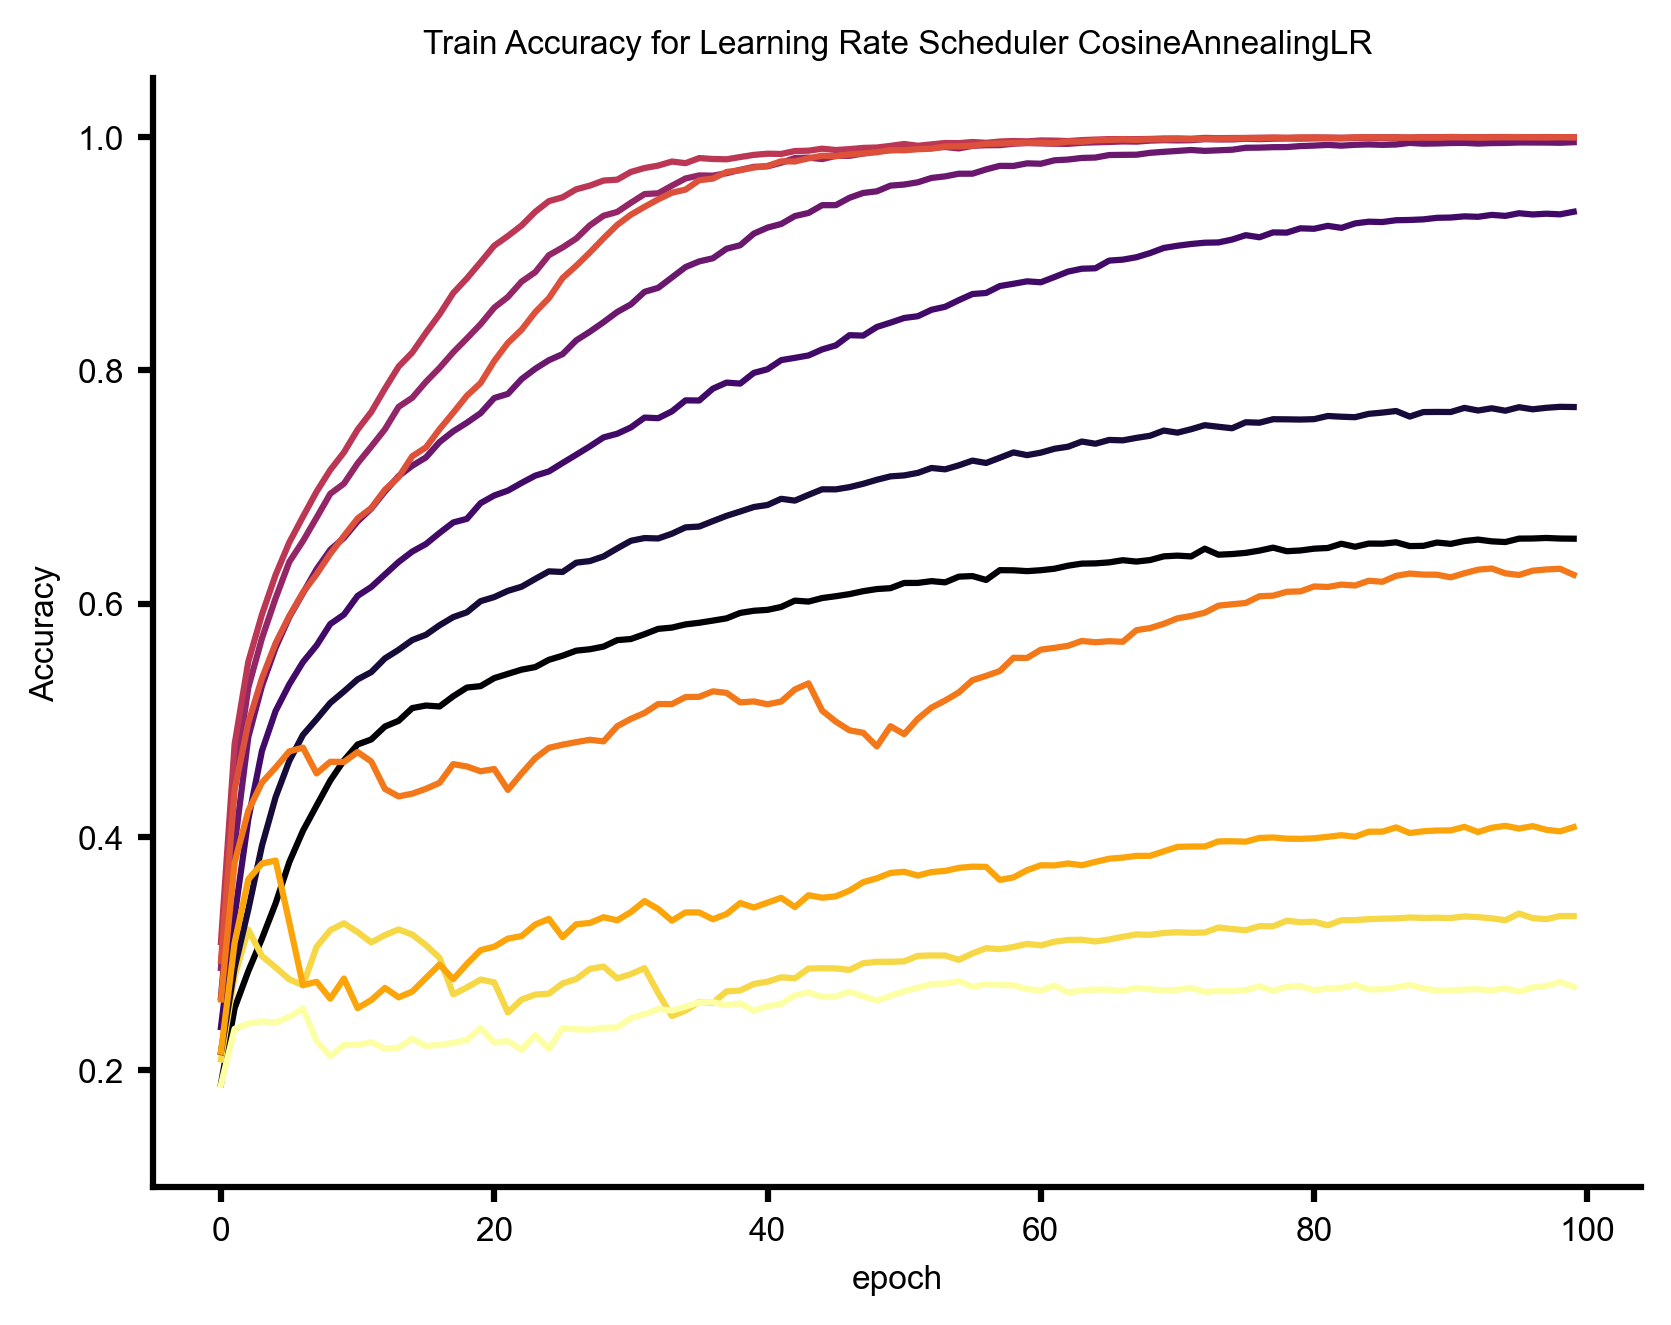

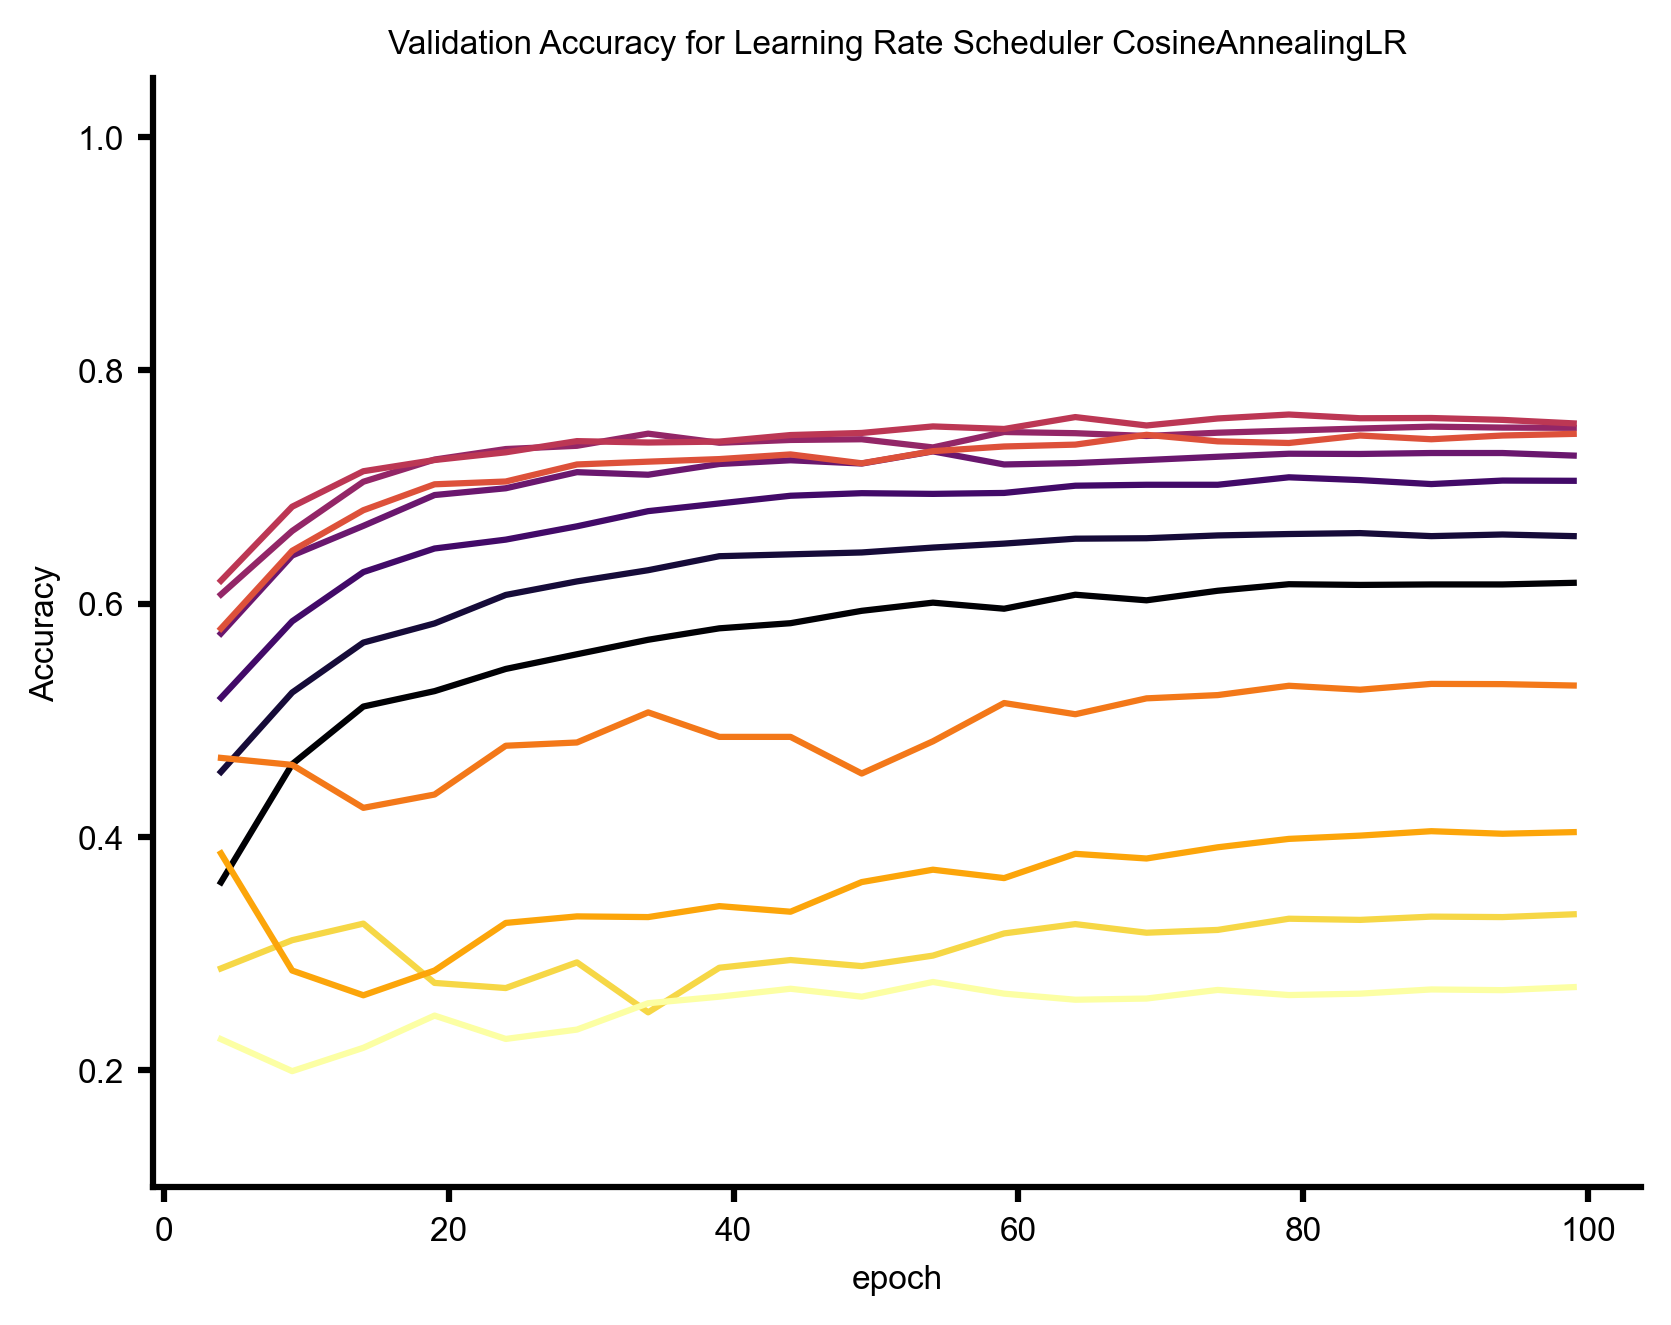

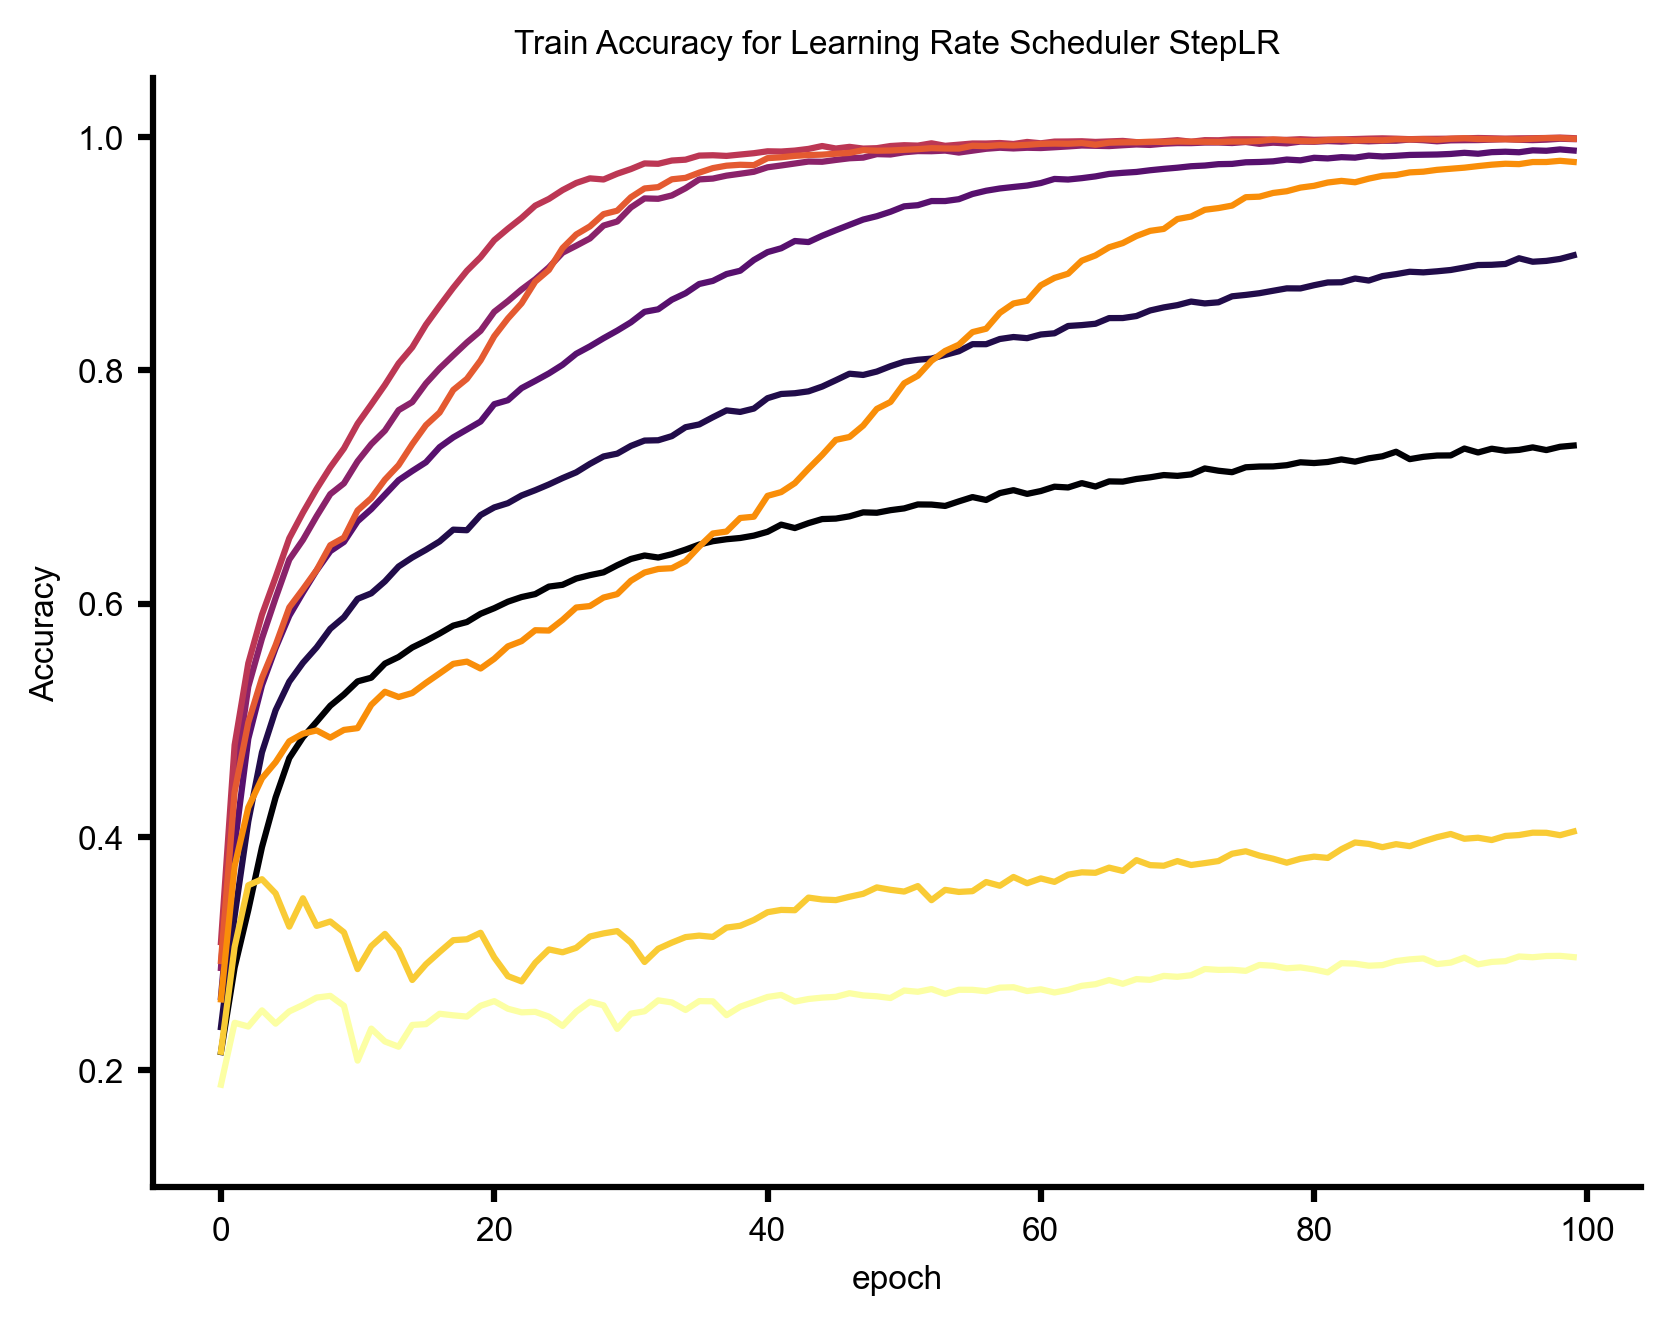

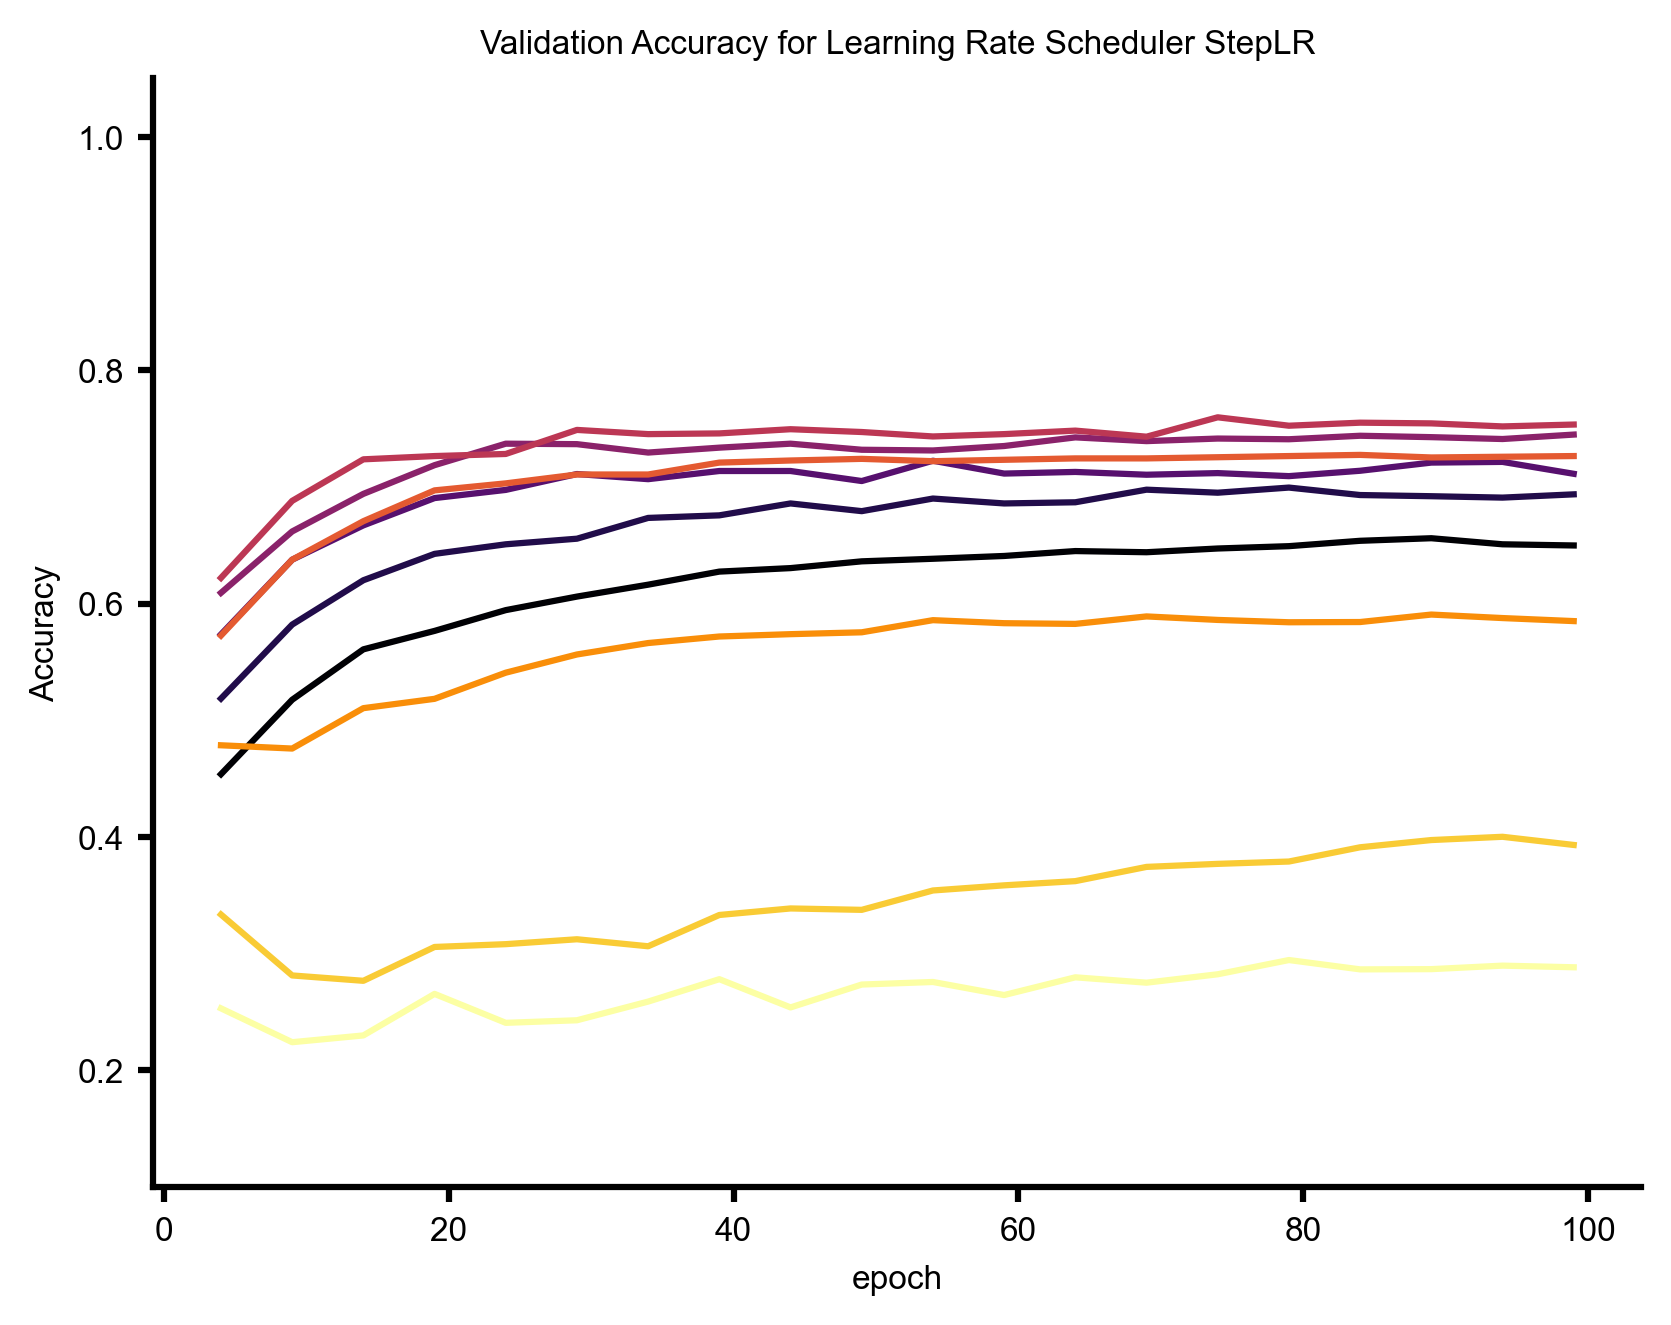

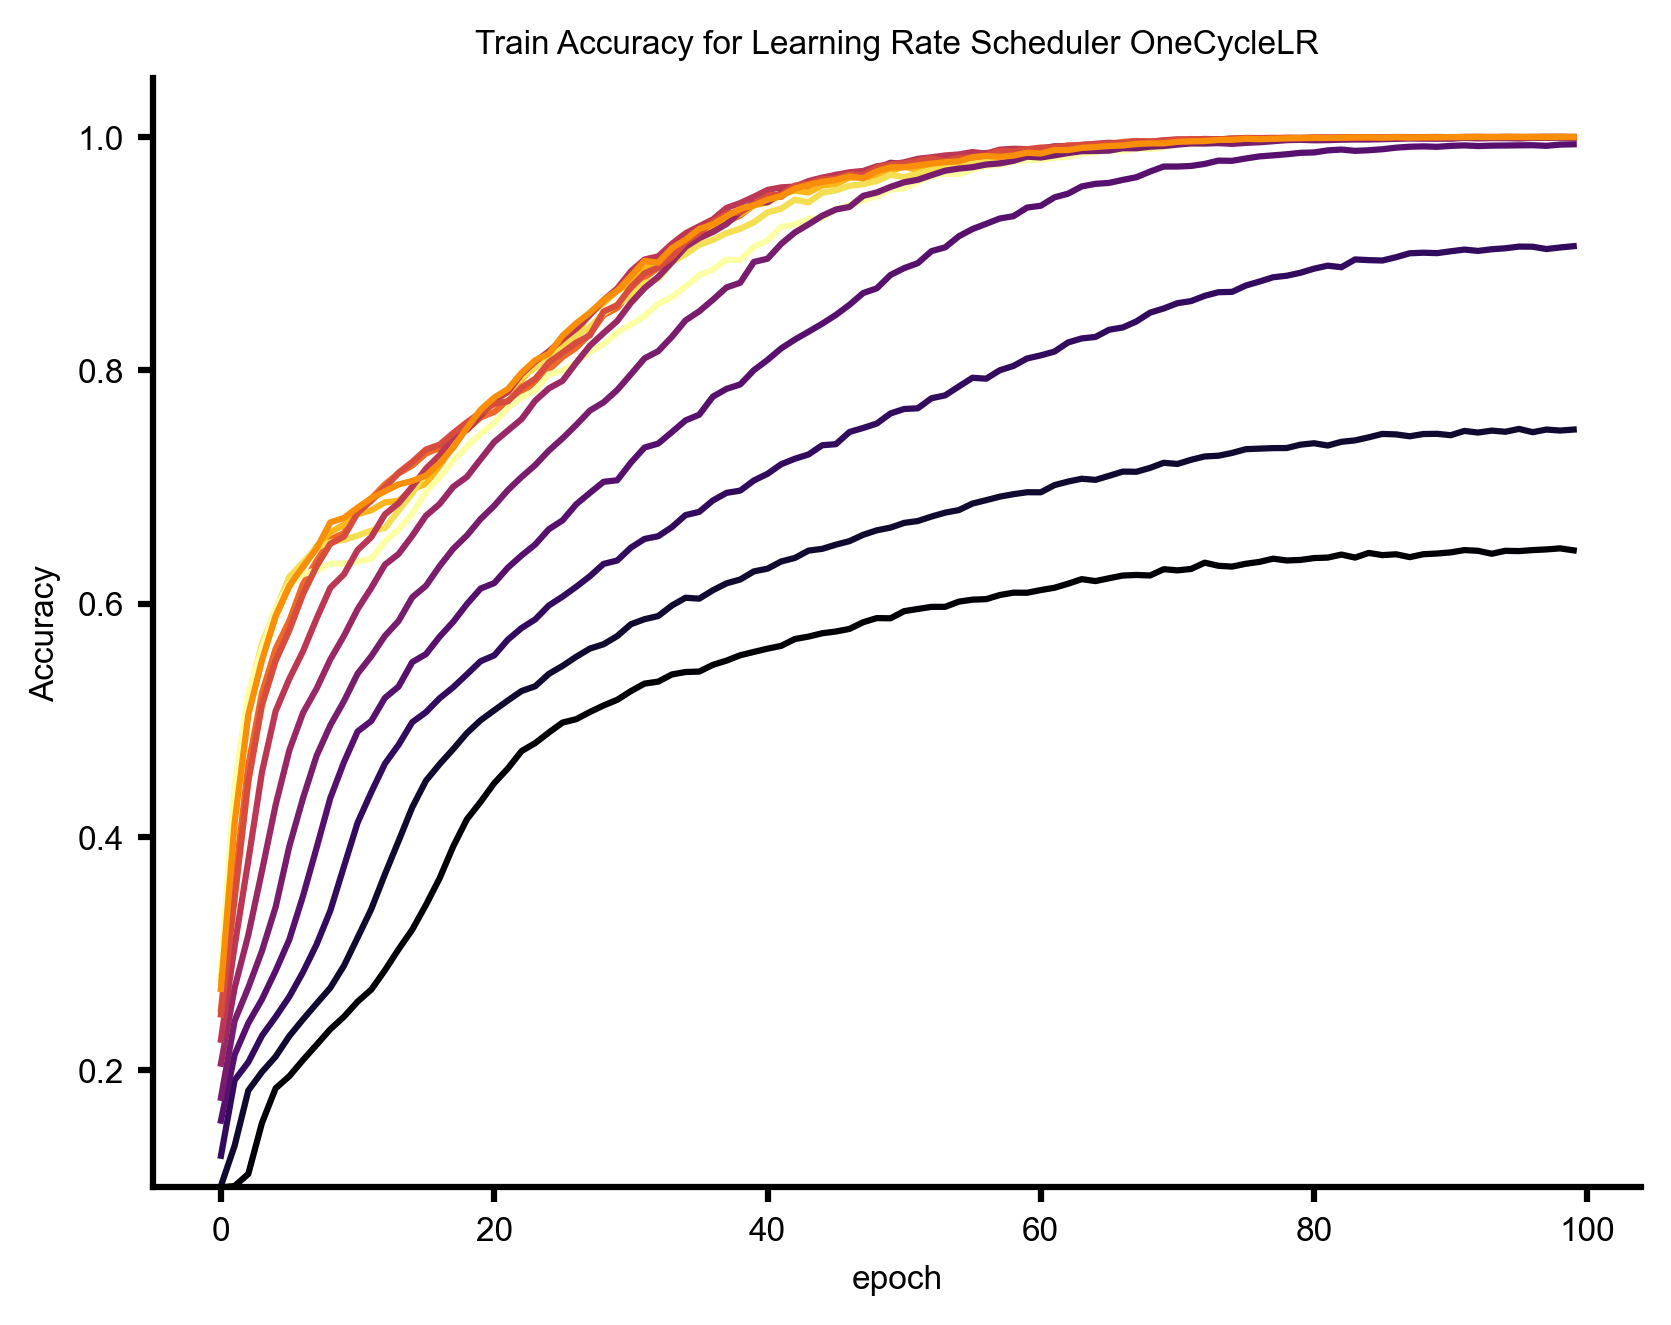

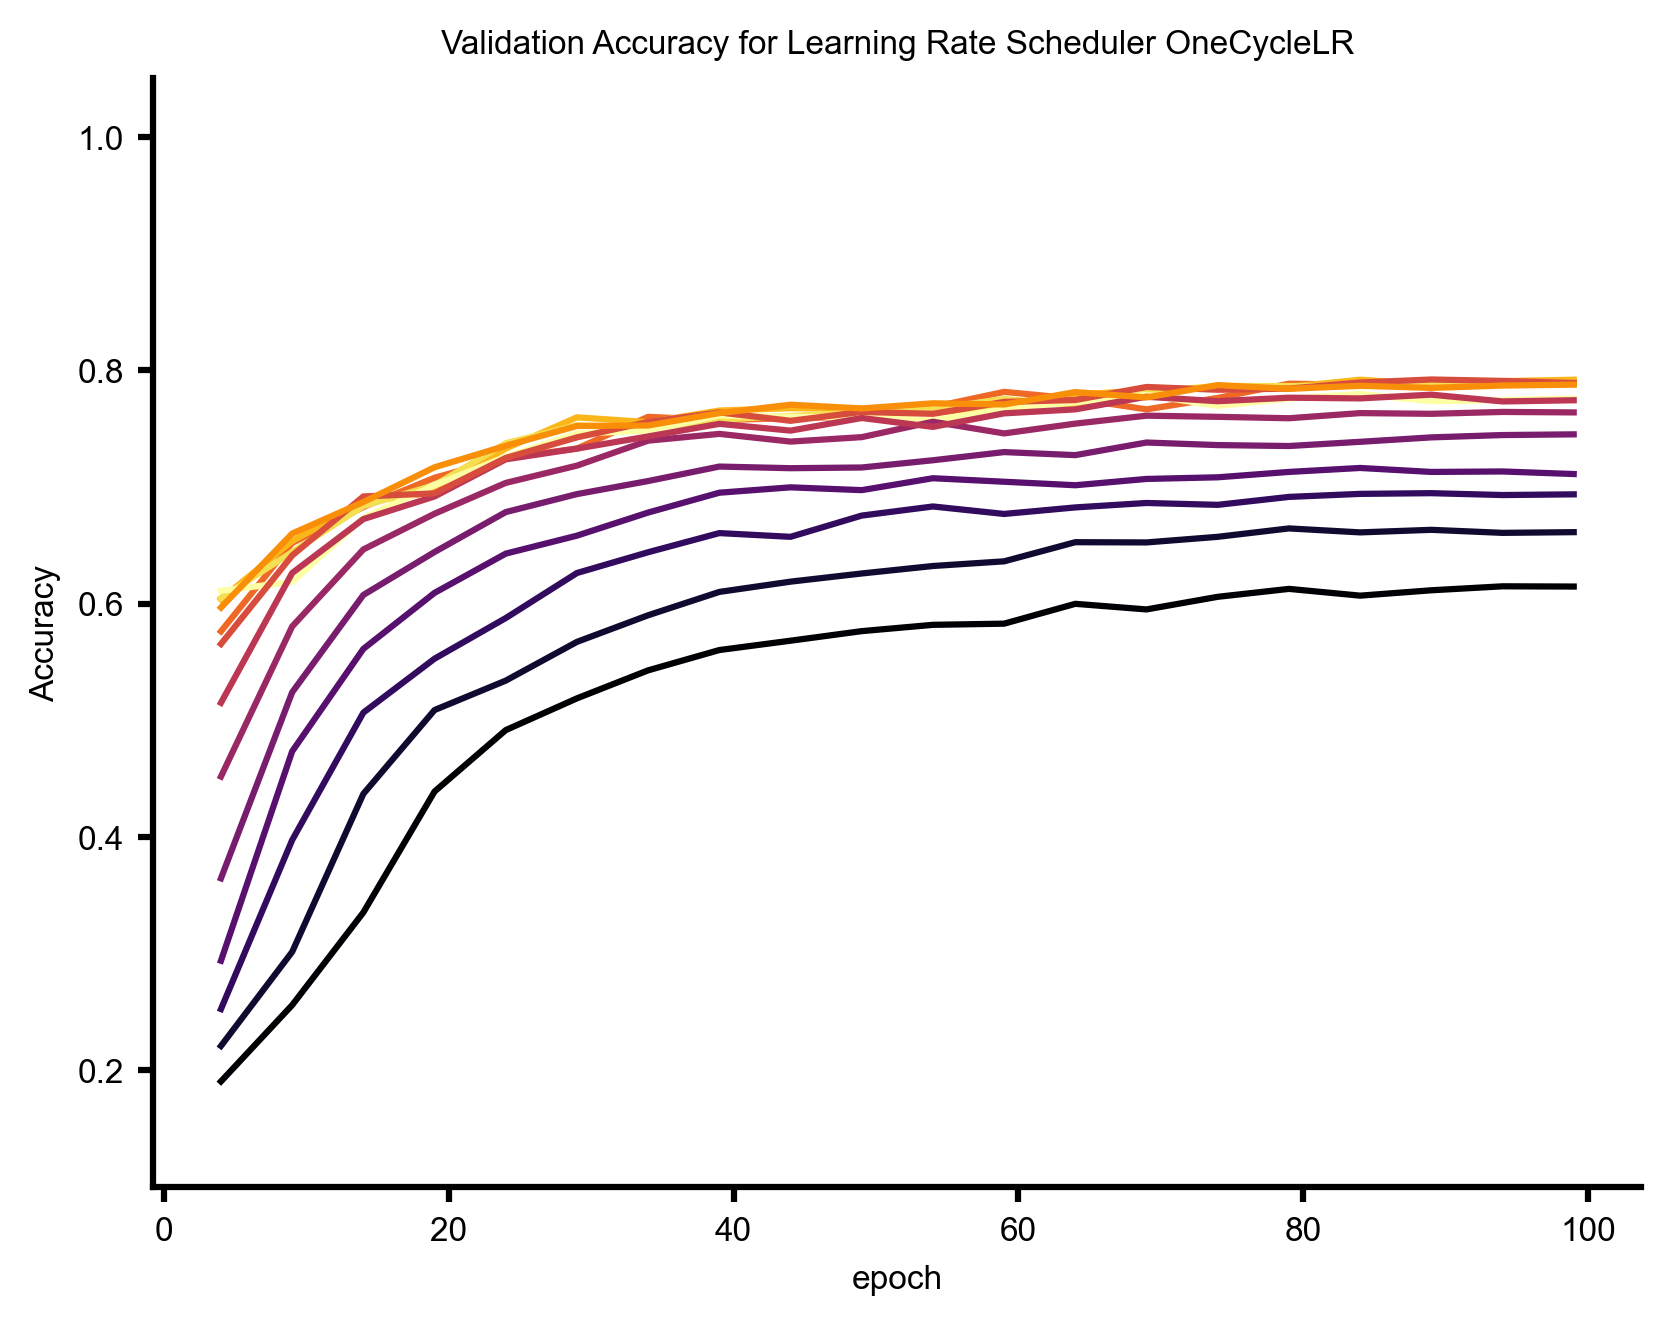

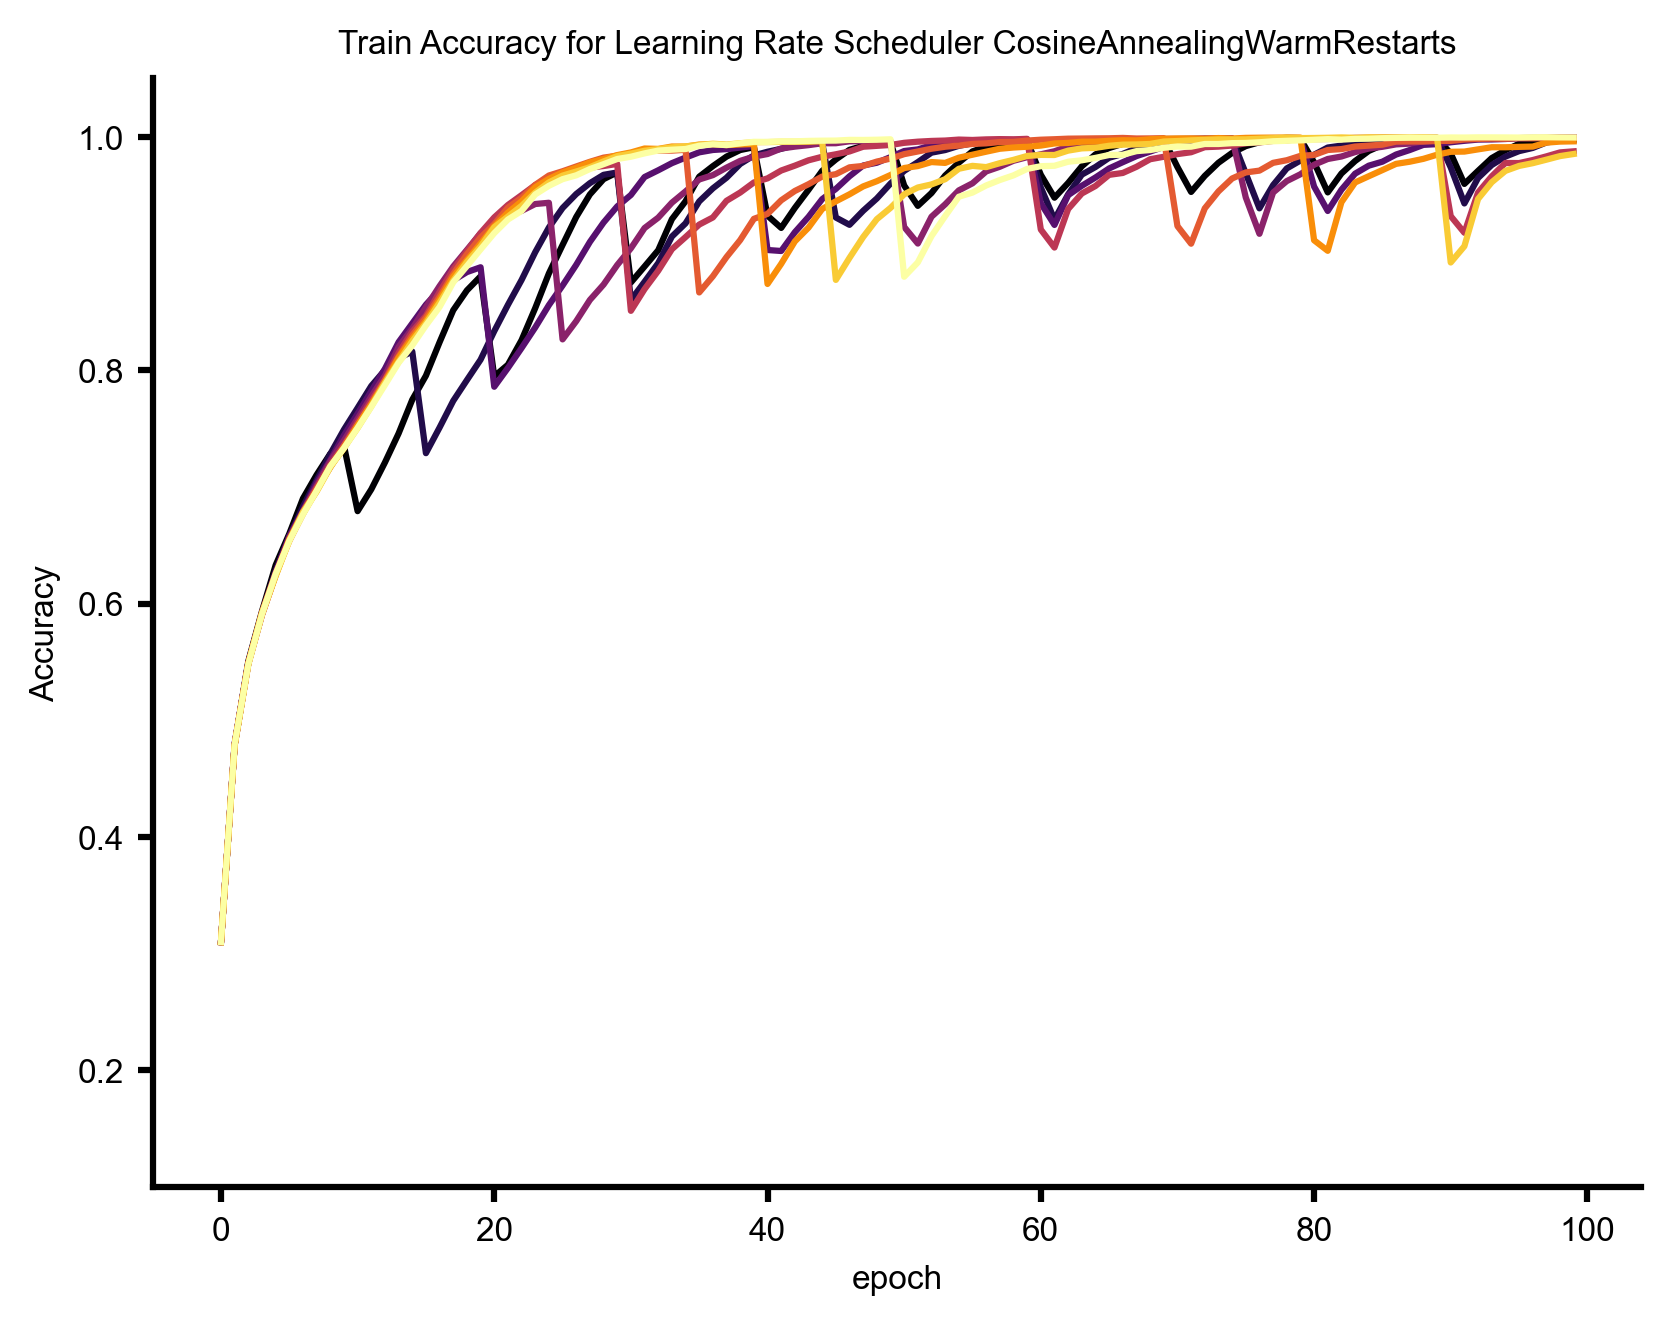

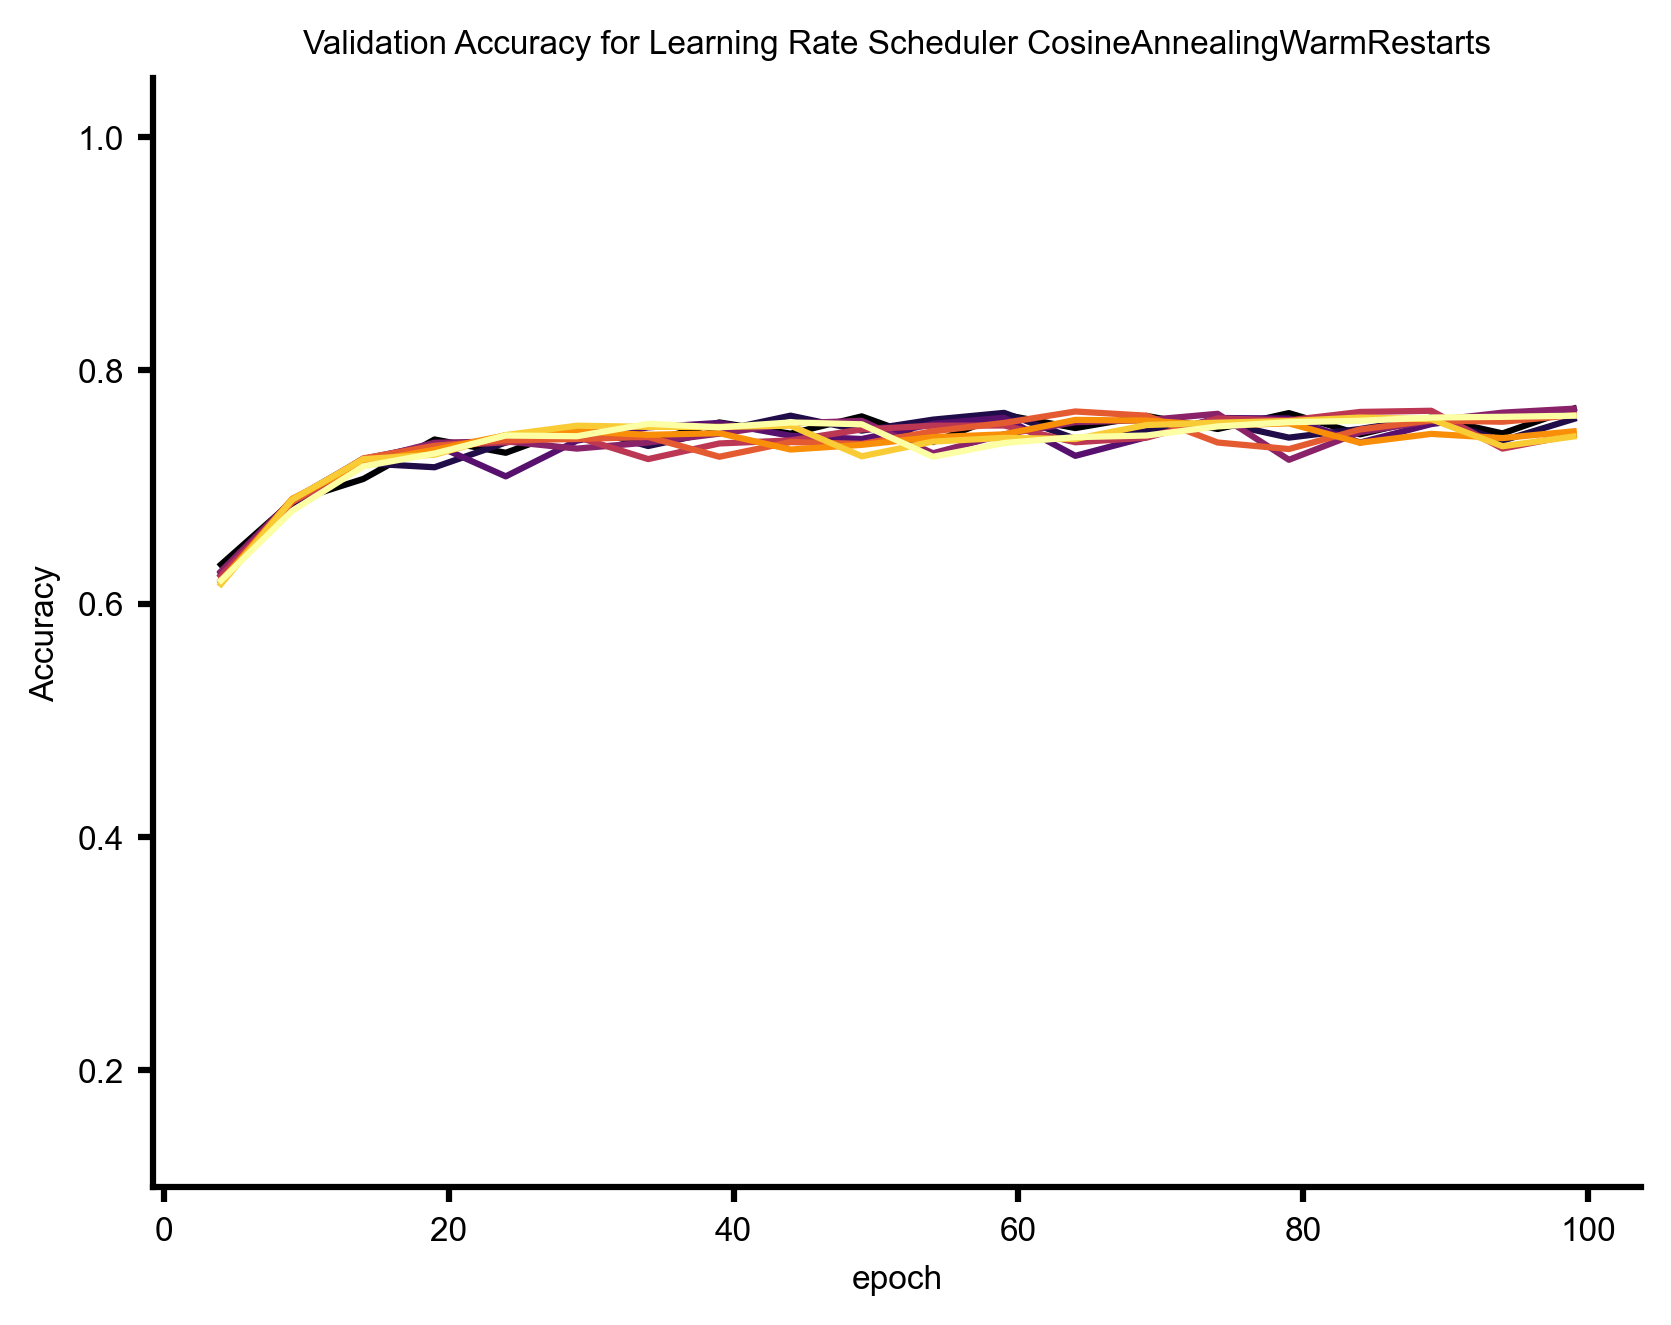

In [206]:
@experiment_plot
def plot_train_results(df: pd.DataFrame, experiment_name: str, colors: Tuple[str, Dict[int, np.ndarray]] = (None, None), data_entity: str = "train") -> Tuple[Figure, Axes]:
    fig, ax = plt.subplots()
    key, colors_dict = colors
    data_entity = data_entity.lower()

    for version in sorted(df["version"].unique()):
        experiment_df = df[(df["experiment_name"] == experiment_name) & (df["version"] == version)][["epoch", f"{data_entity}_acc_epoch", key]].dropna()
        if len(experiment_df) == 0:
            continue
        experiment_df = experiment_df.set_index("epoch")
        
        value = experiment_df[key].unique()[0]
        color = colors_dict[value]
        ax.plot(experiment_df, c=color[:3], label=f"{value:.5f}")
    
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("epoch")
    ax.set_ylim([0.1, 1.05])
    data_entity_dict = {'train': 'Train', 'val': 'Validation', 'test': 'Test'}
    ax.set_title(f"{data_entity_dict[data_entity]} Accuracy for Learning Rate Scheduler {experiment_name}")
    # ax.legend(title=key)
    return fig, ax


# get colors

key = "lr" 
experiment_name = "CosineAnnealingLR"
colors = (key, get_color(results_df, experiment_name, key, cmap_name="inferno"))
plot_train_results(results_df, experiment_name, colors, "train")
plot_train_results(results_df, experiment_name, colors, "val")

key = "lr" 
experiment_name = "StepLR"
colors = (key, get_color(results_df, experiment_name, key, cmap_name="inferno"))
plot_train_results(results_df, experiment_name, colors, "train")
plot_train_results(results_df, experiment_name, colors, "val")


key = "lr" 
experiment_name = "OneCycleLR"
colors = (key, get_color(results_df, experiment_name, key, cmap_name="inferno"))
plot_train_results(results_df, experiment_name, colors, "train")
plot_train_results(results_df, experiment_name, colors, "val")


# key = "max_lr" 
# experiment_name = "OneCycleLR2"
# colors = (key, get_color(results_df, experiment_name, key, cmap_name="inferno"))
# plot_train_results(results_df, experiment_name, colors, "train")
# plot_train_results(results_df, experiment_name, colors, "val")


key = "lr" 
experiment_name = "BaselineClassifier"
colors = (key, get_color(results_df, experiment_name, key, cmap_name="inferno"))
plot_train_results(results_df, experiment_name, colors, "train")
plot_train_results(results_df, experiment_name, colors, "val")


key = "T_0" 
experiment_name = "CosineAnnealingWarmRestarts"
colors = (key, get_color(results_df, experiment_name, key, cmap_name="inferno"))
plot_train_results(results_df, experiment_name, colors, "train")
plot_train_results(results_df, experiment_name, colors, "val")



In [207]:
@experiment_plot
def plot_test_acc(df: pd.DataFrame, experiment_name: str = None):
    fig, ax = plt.subplots()
    df = (
        df[["experiment_name", "lr", "test_acc"]]
        .groupby(["experiment_name", "lr"])
        .max()
    )
    df = df.reset_index()

    # if experiment_name is not None:
    #     primary_df = df[df["experiment_name"] == experiment_name]
    #     secondary_df = df[df["experiment_name"] != experiment_name]
    #     secondary_df["experiment_name"] = "others"
    #     df = pd.concat([primary_df, secondary_df])


    ax = sns.scatterplot(df, y="test_acc", x="lr", hue="experiment_name", ax=ax)
    ax.set_xscale("log")

    return fig, ax

plot_test_acc(results_df, experiment_name="BaselineClassifier")

No such experiment BaselineClassifier. Please choose from: ['CosineAnnealingLR' 'StepLR' 'ConstantLR' 'OneCycleLR'
 'CosineAnnealingWarmRestarts']


/home/robin/miniconda3/envs/DLRK/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


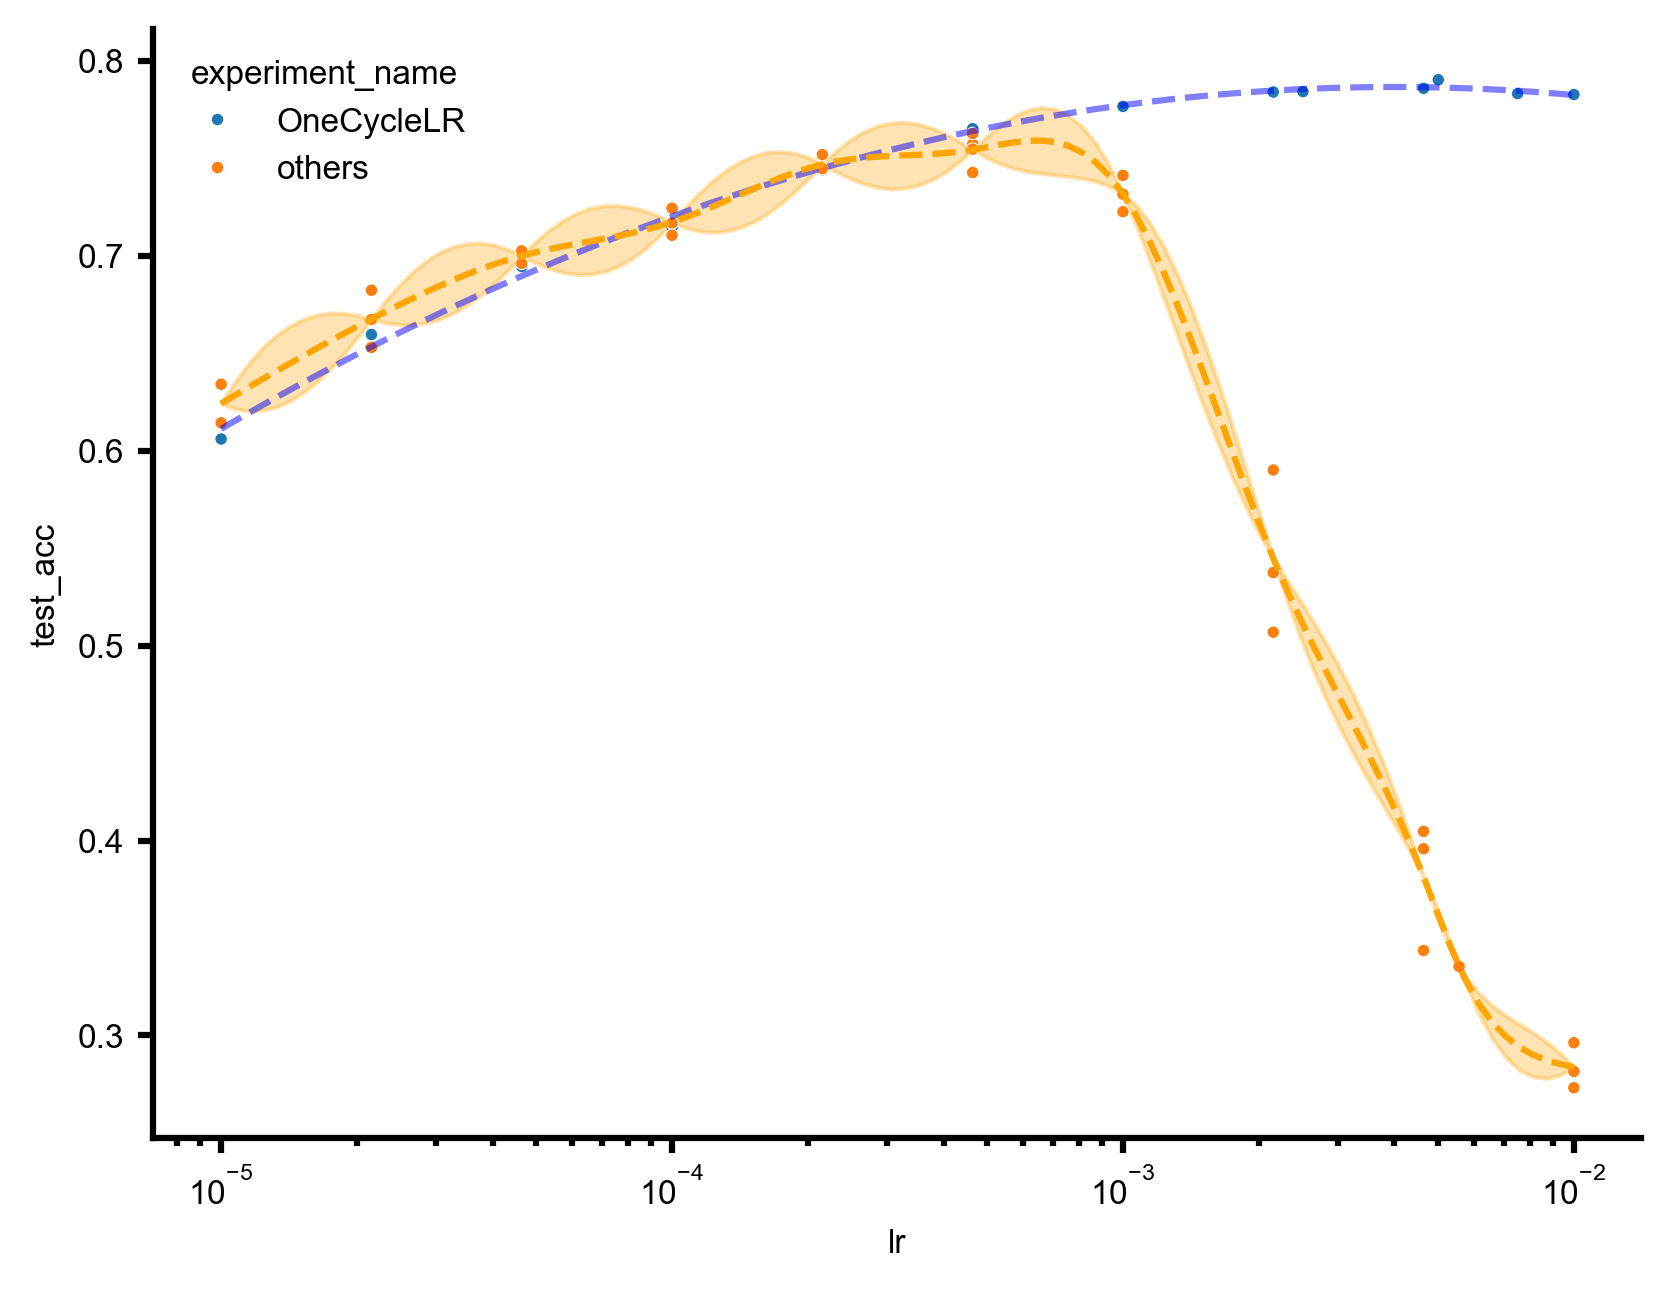

In [208]:
fig, ax = plt.subplots()

df = (
    results_df[["experiment_name", "lr", "test_acc"]]
    .groupby(["experiment_name", "lr"])
    .max()
)
df = df.reset_index()
one_cycle_lr_df = df[df["experiment_name"] == "OneCycleLR"]
rest_df = df[df["experiment_name"] != "OneCycleLR"].dropna()
rest_df["experiment_name"] = "others"
concat_df = pd.concat([one_cycle_lr_df, rest_df])

degree = 2
x = np.stack([np.log(one_cycle_lr_df["lr"]) ** i for i in range(degree + 1)]).T
y = np.linalg.inv(x.T @ x) @ x.T @ one_cycle_lr_df["test_acc"].to_numpy()
x = np.stack(
    [np.linspace(x[:, 1].min(), x[:, 1].max(), 100) ** i for i in range(degree + 1)]
).T
ax.plot(np.exp(x[:, 1]), x @ y, "--", alpha=0.5, color="b",)


kernel = Matern(length_scale=0.09)
# kernel = RBF(length_scale=0.01)
gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=50)

xy = rest_df[["lr", "test_acc"]].to_numpy().T
x = np.log(xy[0][:, None])
y = xy[1][:, None]
gp.fit(x, y)

x = np.linspace(x.min(), x.max(), 100)
y_pred, sigma = gp.predict(x[:, None], return_std=True)
ax.plot(np.exp(x), y_pred, "--", color="orange")
ax.fill_between(
    np.exp(x.ravel()),
    y_pred.ravel() - 1 * sigma,
    y_pred.ravel() + 1 * sigma,
    alpha=0.3,
    color="orange"
    # ec="None",
    # label="95% confidence interval",
)

# degree = 3
# rest_df = rest_df.sort_values("lr")
# x = np.stack([np.log(rest_df["lr"]) ** i for i in range(degree + 1)]).T
# y = np.linalg.inv(x.T @ x) @ x.T @ rest_df["test_acc"].to_numpy()
# x = np.stack(
#     [np.linspace(x[:, 1].min(), x[:, 1].max(), 100) ** i for i in range(degree + 1)]
# ).T
# ax.plot(np.exp(x[:, 1]), x @ y, alpha=0.5)

sns.scatterplot(concat_df, y="test_acc", x="lr", hue="experiment_name", ax=ax)

ax.set_xscale("log")


                experiment_name  version  val_acc_epoch
0                    ConstantLR        6         0.4730
1                    ConstantLR        8         0.6450
2                    ConstantLR       10         0.6866
3                    ConstantLR       12         0.7084
4                    ConstantLR       14         0.7310
5                    ConstantLR       16         0.7530
6                    ConstantLR       18         0.7518
7                    ConstantLR       20         0.7370
8                    ConstantLR       22         0.5094
9                    ConstantLR       24         0.3336
10                   ConstantLR       26         0.2784
11            CosineAnnealingLR        0         0.6178
12            CosineAnnealingLR        2         0.3338
13            CosineAnnealingLR        6         0.6604
14            CosineAnnealingLR        8         0.7082
15            CosineAnnealingLR       10         0.7304
16            CosineAnnealingLR       12        

<Axes: xlabel='epoch', ylabel='val_acc_epoch'>

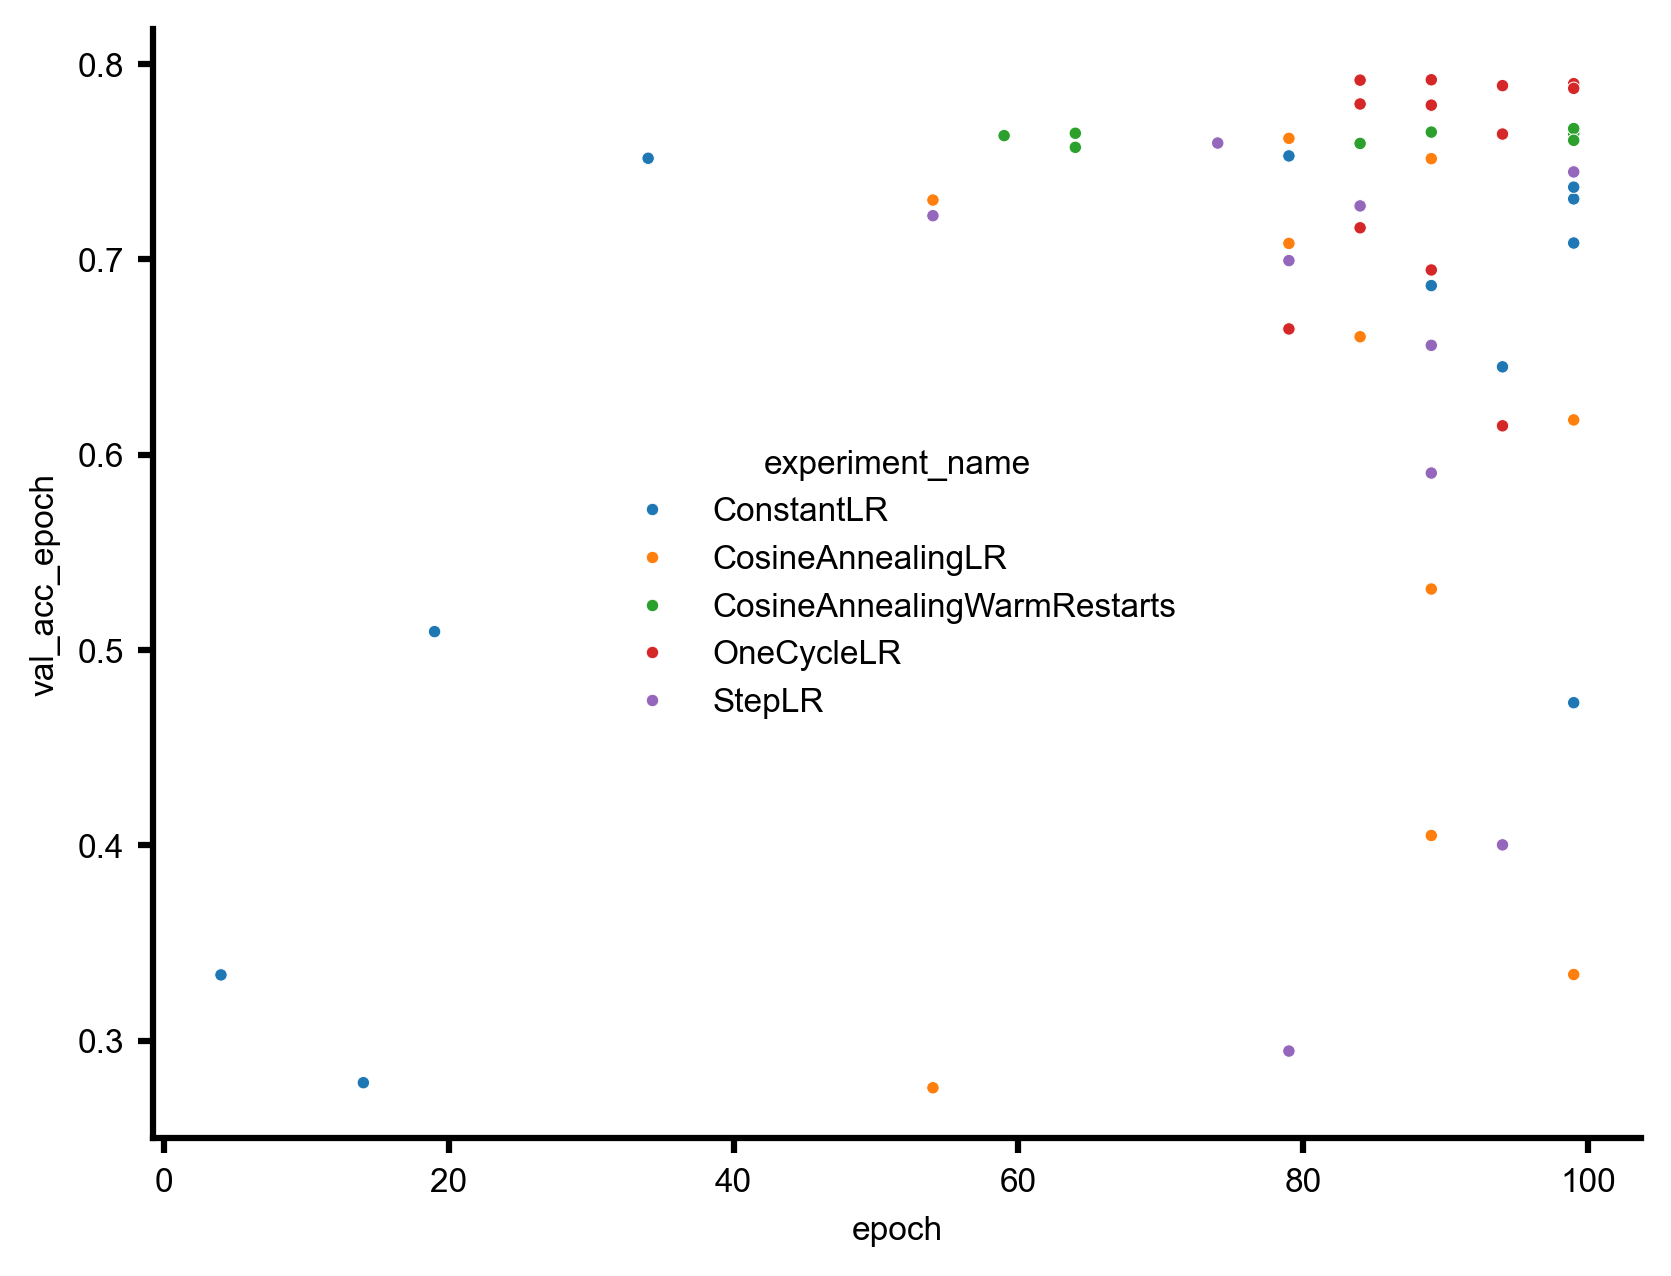

In [209]:
df = results_df.groupby(["experiment_name", "version"]).max()["val_acc_epoch"]
df = df.reset_index()
print(df)

# Construct the search query string
res = df.copy()
epochs = []
for idx in range(len(df)):
    a = results_df[
        (results_df["experiment_name"] == df.iloc[idx]["experiment_name"])
        & (results_df["version"] == df.iloc[idx]["version"])
        & (results_df["val_acc_epoch"] == df.iloc[idx]["val_acc_epoch"])
    ]
    epochs.append(a["epoch"].values[0])

epochs = np.array(epochs)
res["epoch"] = epochs
sns.scatterplot(res, x="epoch", y="val_acc_epoch", hue="experiment_name")


              test_acc
lr-AdamW              
1.135878e-05    0.7627
1.135878e-05    0.7627
4.579558e-07    0.7625
4.579558e-07    0.7625
3.684923e-04    0.7610
3.684923e-04    0.7610
2.857283e-06    0.7565
2.857283e-06    0.7565
2.502882e-04    0.7512
2.502882e-04    0.7512
3.285112e-05    0.7620
3.285112e-05    0.7620
1.603630e-04    0.7556
1.603630e-04    0.7556
4.198357e-04    0.7606
4.198357e-04    0.7606
1.830016e-06    0.7560
1.830016e-06    0.7560


<Axes: xlabel='lr-AdamW'>

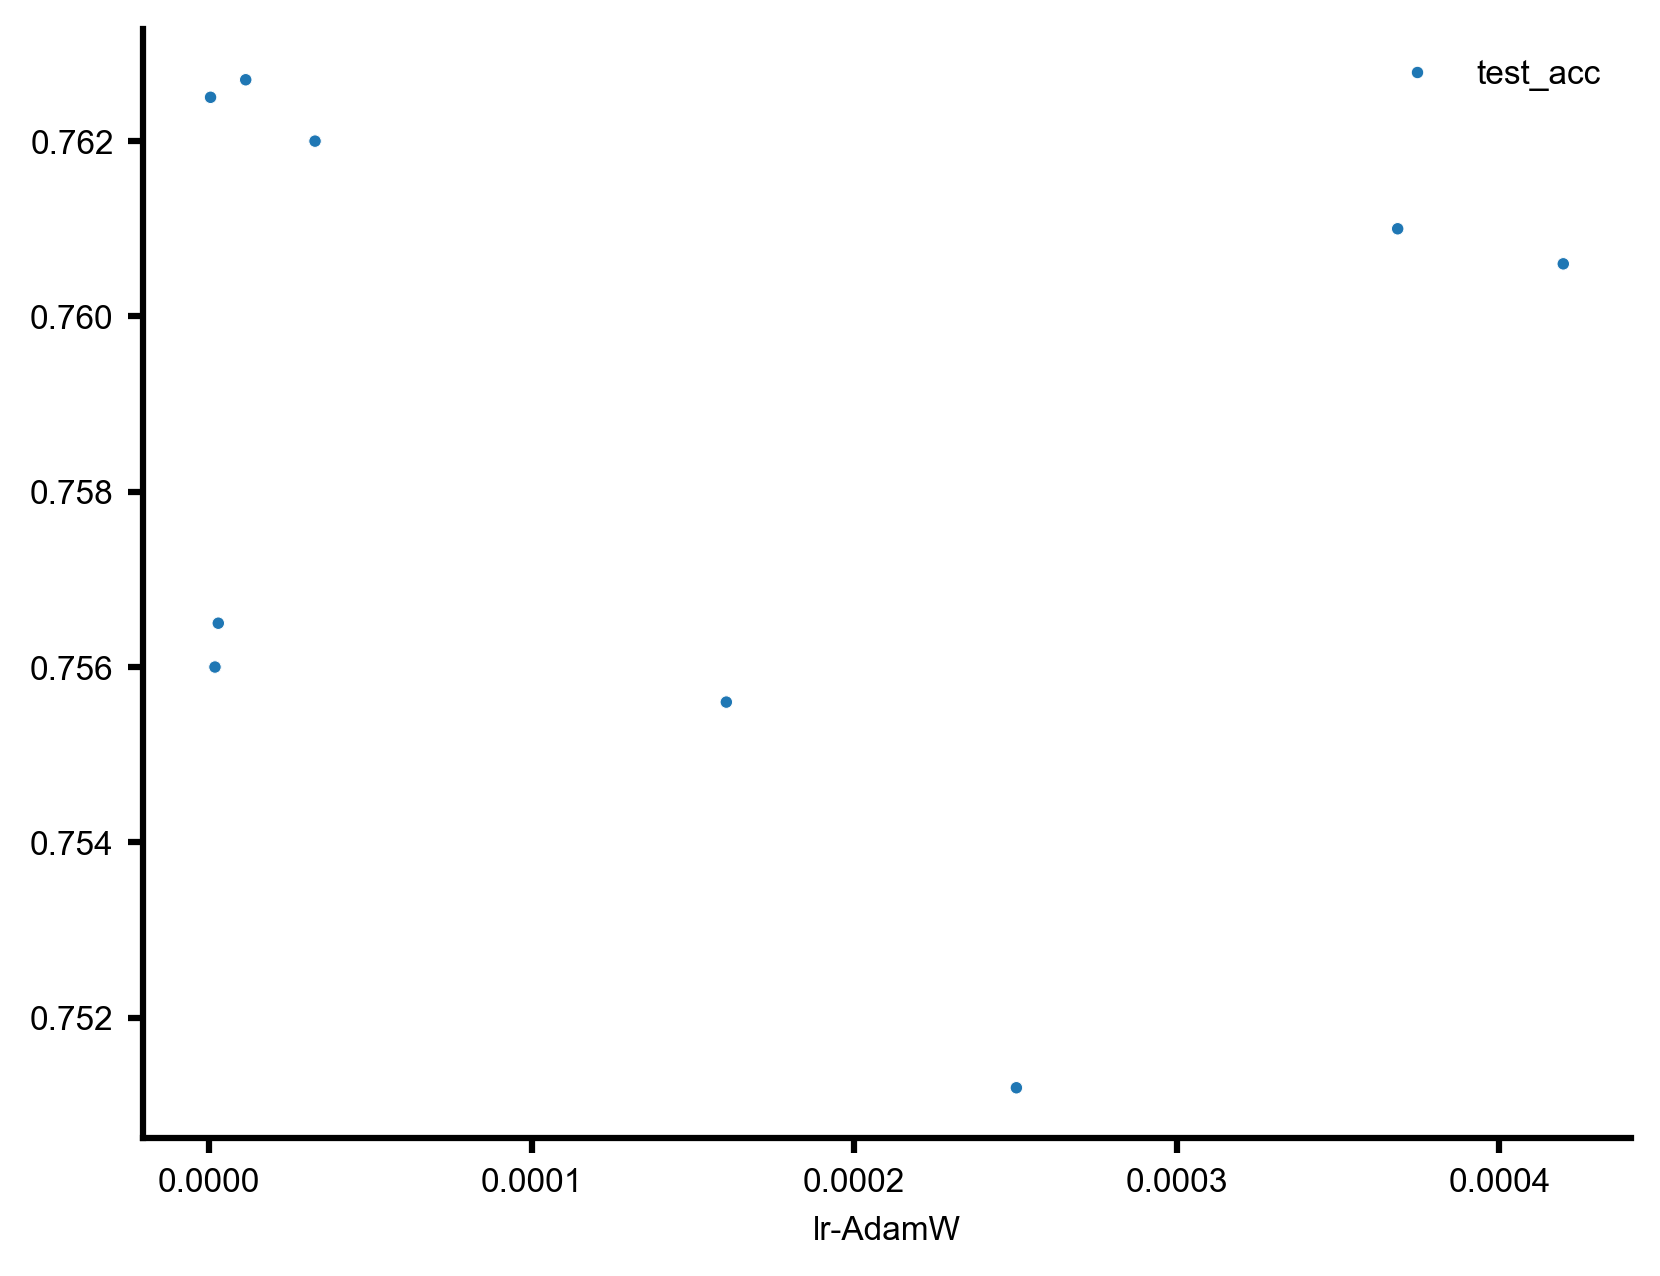

In [210]:
df = results_df[(results_df["experiment_name"] == "CosineAnnealingWarmRestarts") &(results_df["epoch"] == 100)][["lr-AdamW", "test_acc"]]
df = df.set_index("lr-AdamW")
print(df)
sns.scatterplot(df)

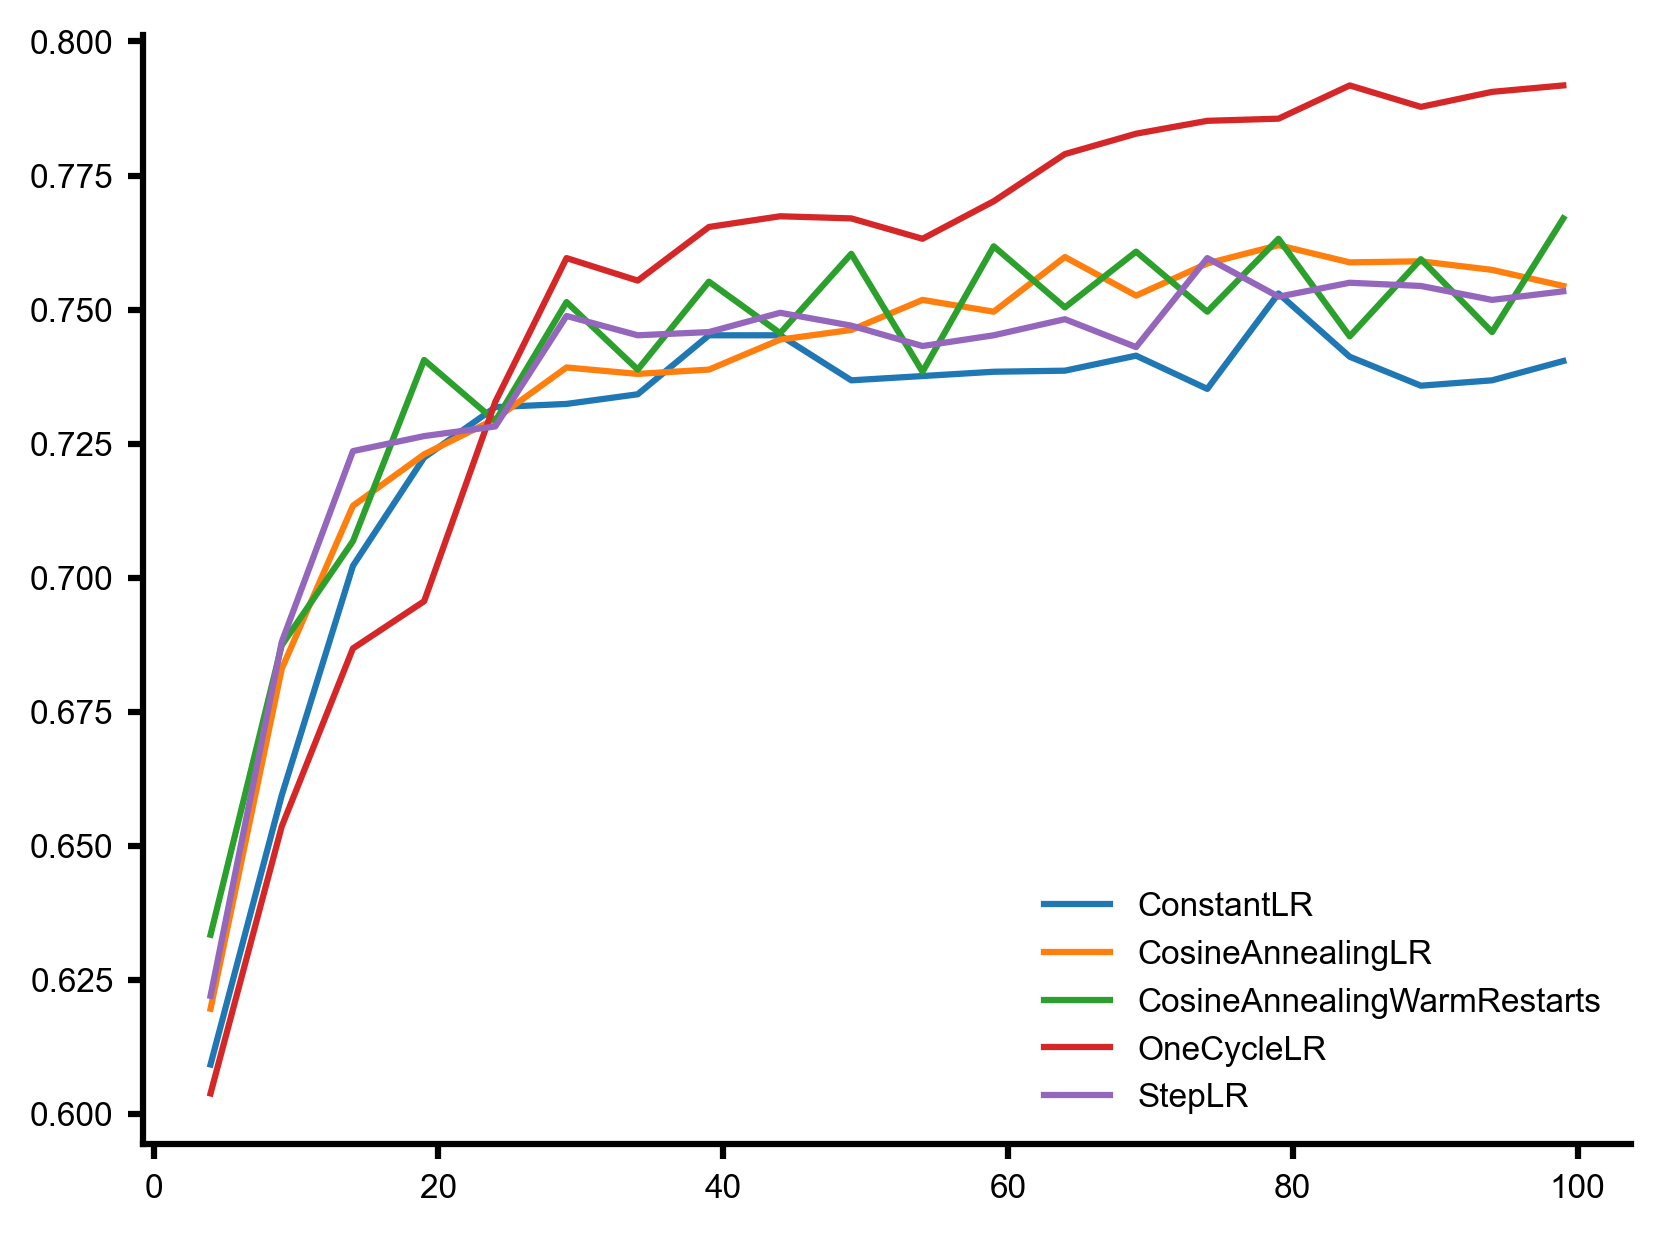

In [213]:
fig, ax = plt.subplots()

best_test_acc = results_df.groupby(["experiment_name"]).max()["test_acc"].reset_index()
query = cerate_equal_query(best_test_acc)
best_version = results_df.query(query)[["experiment_name", "version"]]
query = cerate_equal_query(best_version)
best_experiments = results_df.query(query)[["experiment_name", "val_acc_epoch", "epoch"]].dropna()

for experiment_name in sorted(best_experiments["experiment_name"].unique()):
    ax.plot(*best_experiments[best_experiments["experiment_name"] == experiment_name][["epoch", "val_acc_epoch"]].to_numpy().T, label=experiment_name)

ax.legend()